In [1]:
from tqdm import tqdm
import cgranges
import gzip
import glob
from matplotlib import pyplot as plt
import matplotlib as mpl
from itertools import groupby
from collections import Counter
import numpy as np
from collections import defaultdict
from multiprocessing import Pool
from math import prod
import scipy

In [2]:
# Read class with contig and mapping intervals
class Read:
    def __init__(self, contig, intervals):
        self.contig: str = contig
        self.intervals: list[tuple[int, int]] = intervals

    # Hashing function
    def __hash__(self):
        return hash((self.contig, self.intervals))

    # Equality function
    def __eq__(self, other):
        return (self.contig, self.intervals) == (other.contig, other.intervals)

In [3]:
def get_canonical_intervals(args):
    pidx: int = args[0]
    reads: list[Read] = args[1]
    result = list()
    breakpoints_set: set[int] = set()
    g = cgranges.cgranges()
    for idx, read in enumerate(reads, 1):
        for start, end in read.intervals:
            g.add("", start, end, idx)
            breakpoints_set.add(start)
            breakpoints_set.add(end)
        for (_, start), (end, _) in zip(read.intervals[:-1], read.intervals[1:]):
            g.add("", start, end, -idx)
    g.index()
    breakpoints: list[int] = sorted(breakpoints_set)
    for s, e in zip(breakpoints[:-1], breakpoints[1:]):
        labels: set[int] = set()
        labels = {l for _, _, l in g.overlap("", s, e)}
        result.append((s, e, labels))
    return pidx, result

In [4]:
def get_reads(args):
    pidx = args[0]
    split_tsv = args[1]
    reads: list[Read] = list()
    ridx: int = 0
    for l in (
        gzip.open(split_tsv, "rt")
        if split_tsv.endswith(".gz")
        else open(split_tsv, "r")
    ):
        if l[0] == "#":
            continue
        ridx += 1
        l = l.strip("\n").split("\t")
        contig = l[2]
        intervals = tuple(
            tuple(
                map(
                    int,
                    i.split(":")[0].split("-"),
                )
            )
            for i in l[5:]
        )
        reads.append(Read(contig, intervals))
    return pidx, reads

In [5]:
split_tsvs = list(glob.glob("output/results/N1/freddie.split/*/split*.tsv*"))
print(len(split_tsvs))

10210


In [6]:
split_reads: list[list[Read]] = [list() for _ in split_tsvs]
with Pool(8) as p:
    for pidx, reads in tqdm(
        p.imap_unordered(
            get_reads,
            enumerate(split_tsvs),
        ),
        total=len(split_tsvs),
    ):
        split_reads[pidx] = reads

100%|██████████| 10210/10210 [00:33<00:00, 308.80it/s]


In [7]:
c_intervals: list[list[tuple[int, int, set[int]]]] = [list() for _ in split_reads]
with Pool(32) as p:
    for pidx, intervals in tqdm(
        p.imap_unordered(get_canonical_intervals, enumerate(split_reads)),
        total=len(split_tsvs),
    ):
        pidx: int
        intervals: list[tuple[int, int, set[int]]]
        c_intervals[pidx] = intervals

100%|██████████| 10210/10210 [02:15<00:00, 75.35it/s] 


In [527]:
A = np.array(
    [
        [3, 2, 1, 2],
        [1, 5, 4, 5],
        [1, 4, 1, 4],
        [-1, 4, 1, 4],
        [1, 4, -1, 4],
    ]
)

np.array(sorted((tuple(tuple(i)) for i in A))), np.take_along_axis(A, np.argsort(A, axis=0), axis=0)  

(array([[-1,  4,  1,  4],
        [ 1,  4, -1,  4],
        [ 1,  4,  1,  4],
        [ 1,  5,  4,  5],
        [ 3,  2,  1,  2]]),
 array([[-1,  2, -1,  2],
        [ 1,  4,  1,  4],
        [ 1,  4,  1,  4],
        [ 1,  4,  1,  4],
        [ 3,  5,  4,  5]]))

In [528]:
def plot_large_intervals(
    INTERVALS, start_idx=-1, end_idx=-1, unique=True, min_height=5, out_prefix=None
):
    if start_idx == -1:
        start_idx = 0
    if end_idx == -1:
        end_idx = len(INTERVALS)
    INTERVALS = INTERVALS[start_idx:end_idx]
    ridx_to_yidx = {
        ridx: yidx
        for yidx, ridx in enumerate(
            sorted({abs(ridx) for _, _, ridxs in INTERVALS for ridx in ridxs})
        )
    }
    read_count = len(ridx_to_yidx)
    fig, axes = plt.subplots(
        2,
        2,
        figsize=(
            15,
            10,
        ),
        sharex=True,
        gridspec_kw={
            "height_ratios": [1, 5],
            "width_ratios": [10, 1],
        },
        squeeze=False,
    )
    plt.subplots_adjust(wspace=0, hspace=0)
    heights_ax = axes[0, 0]
    imshow_ax = axes[1, 0]
    dend_ax = axes[1, 1]
    fig.subplots_adjust(hspace=0)
    heights = [e - s for s, e, _ in INTERVALS]
    heights_ax.bar(
        np.arange(0, len(heights), 1),
        heights,
        width=1,
        color=["red" if h < min_height else "blue" for h in heights],
    )
    heights_ax.set_ylabel("Interval length", size=10)
    heights_ax.set_ylim(0, 50)
    yticks = np.arange(5, 50 + 1, 5)
    heights_ax.set_yticks(yticks)
    heights_ax.set_yticklabels(yticks, size=8)
    heights_ax.grid()

    matrix = np.ones((read_count, len(INTERVALS)), dtype=np.int8)
    for i, (_, _, ridxs) in enumerate(INTERVALS):
        for ridx in ridxs:
            matrix[ridx_to_yidx[abs(ridx)], i] = 0 if ridx < 0 else -1
    if unique:
        matrix = np.unique(matrix, axis=0)
    unique_read_count = matrix.shape[0]
    # Sort rows by their columns
    # col_std = np.std(matrix, axis=0)
    # L = scipy.cluster.hierarchy.linkage(matrix * col_std, metric="cityblock")
    # dend = scipy.cluster.hierarchy.dendrogram(
    #     L,
    #     ax=dend_ax,
    #     no_labels=True,
    #     orientation="right",
    # )
    # dend_ax.invert_yaxis()
    # idx = dend["leaves"]
    # matrix = matrix[idx, :]
    matrix *= -1
    matrix = np.array(sorted((tuple(tuple(i)) for i in matrix)))
    imshow_ax.imshow(matrix, cmap="binary", aspect="auto", interpolation="none")

    consensus_cols = [
        all(ridx < 0 for ridx in ridxs) or all(ridx > 0 for ridx in ridxs)
        for _, _, ridxs in INTERVALS
    ]
    for i, flag in enumerate(consensus_cols):
        if flag:
            imshow_ax.axvline(i, color="green", linewidth=1)

    imshow_ax.set_ylabel(
        f"Read index (n={len(ridx_to_yidx)}, u={unique_read_count})", size=10
    )
    imshow_ax.set_xlabel("Interval index", size=10)
    xticks = np.arange(0, len(INTERVALS) + 1, max(1, len(INTERVALS) // 30))
    starts = [s for s, _, _ in INTERVALS] + [INTERVALS[-1][1]]
    imshow_ax.set_xticks(xticks - 0.5)
    imshow_ax.set_xticklabels(
        [f"{t}) {starts[i]:,}" for i, t in enumerate(xticks + start_idx)],
        size=8,
        rotation=90,
    )
    yticks = np.arange(0, unique_read_count, max(1, unique_read_count // 30))
    imshow_ax.set_yticks(yticks - 0.5)
    imshow_ax.set_yticklabels(yticks.astype(int), size=8)
    if out_prefix is not None:
        plt.savefig(f"{out_prefix}.png", dpi=500, bbox_inches="tight")
        plt.savefig(f"{out_prefix}.pdf", bbox_inches="tight")
    imshow_ax.grid(which="major", axis="both")

    for ax in axes[:, 1]:
        ax.tick_params(
            axis="both",
            which="both",
            left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False,
        )
        for _, spine in ax.spines.items():
            spine.set_visible(False)
    plt.tight_layout()
    plt.show()
    return matrix

In [371]:
RGB_dict = {
    "e": (0, 0, 0),  # black
    "i": (0.5, 0.5, 0.5),  # gray
    "E": (0.2, 0.8, 0.2),  # green
    "N": (0.8, 0.2, 0.2),  # red
}


def get_coloring(ridx):
    if ridx > 0:
        return "e"
    else:
        return "i"


def merge_by_key(S):
    result = defaultdict(set)
    for i, k in S:
        result[k].add(i)
    return sorted(dict(result).items())


def merge_intervals(intervals):
    def do_merge(intervals):
        for idx, (_, _, ridxs) in enumerate(intervals[:-1]):
            next_ridxs = intervals[idx + 1][2]
            if all(ridx < 0 for ridx in next_ridxs):  # no exons
                continue
            added_ridxs = next_ridxs - ridxs
            if any(ridx < 0 for ridx in added_ridxs):
                continue
            removed_ridxs = sorted(ridxs - next_ridxs)
            for ridx in removed_ridxs:
                if ridx > 0:
                    intervals[idx + 1][2].add(ridx)

    result = [(s, e, {ridx for ridx in ridxs}) for s, e, ridxs in intervals]
    do_merge(result)
    result.reverse()
    do_merge(result)
    result.reverse()
    return result


def compressed_intervals(INTERVALS):
    result = list()
    last = INTERVALS[0]
    for curr in INTERVALS[1:]:
        if curr[2] != last[2]:
            result.append(last)
            last = curr
        else:
            last = (last[0], curr[1], last[2])
    result.append(last)
    return result

In [9]:
def get_compressed_intervals(args):
    pidx = args[0]
    intervals = args[1]
    return pidx, compressed_intervals(merge_intervals(intervals))

In [10]:
compressed_c_intervals: list[list[tuple[int, int, set[int]]]] = [
    list() for _ in c_intervals
]
with Pool(32) as p:
    for pidx, intervals in tqdm(
        p.imap_unordered(
            get_compressed_intervals,
            enumerate(c_intervals),
        ),
        total=len(c_intervals),
    ):
        pidx: int
        intervals: list[tuple[int, int, set[int]]]
        compressed_c_intervals[pidx] = intervals

100%|██████████| 10210/10210 [01:47<00:00, 94.69it/s] 


In [125]:
def get_enum_interval_len(x: tuple[int, tuple[int, int, set[int]]]):
    _, (s, e, _) = x
    return e - s


def pop_intervals(intervals, min_len, merge_and_compress=True):
    result: list[tuple[int, int, set[int]]] = [
        (s, e, ridxs) for s, e, ridxs in intervals
    ]
    drop_idxs = set()
    for is_short, g in groupby(
        enumerate(intervals), key=lambda x: get_enum_interval_len(x) < min_len
    ):
        if not is_short:
            continue
        idxs, _ = zip(*g)
        if len(idxs) == 1:
            idx = idxs[0]
            s, e, ridxs = result[idx]
            if idx == 0:
                result[idx + 1] = (
                    s,
                    intervals[idx + 1][1],
                    intervals[idx + 1][2],
                )
            elif idx == len(result) - 1:
                result[idx - 1] = (intervals[idx - 1][0], e, intervals[idx - 1][2])
            else:
                pre_s, _, pre_ridxs = intervals[idx - 1]
                _, post_e, post_ridxs = intervals[idx + 1]
                cost_a = len(pre_ridxs - ridxs)
                cost_b = len(post_ridxs - ridxs)
                if cost_a < cost_b:
                    result[idx - 1] = (pre_s, e, pre_ridxs)
                else:
                    result[idx + 1] = (s, post_e, post_ridxs)
            drop_idxs.add(idx)
        else:
            counter = defaultdict(Counter)
            new_s = intervals[idxs[0]][0]
            new_e = intervals[idxs[-1]][1]
            new_ridxs = set()
            for s, e, ridxs in intervals[idxs[0] : idxs[-1] + 1]:
                for ridx in ridxs:
                    counter[abs(ridx)][ridx > 0] += e - s
            for ridx in counter:
                if counter[ridx][True] > counter[ridx][False]:
                    new_ridxs.add(ridx)
                else:
                    new_ridxs.add(-ridx)
            result[idxs[0]] = (new_s, new_e, new_ridxs)
            drop_idxs.update(idxs[1:])
    result = [x for i, x in enumerate(result) if i not in drop_idxs]
    if merge_and_compress:
        return compressed_intervals(merge_intervals(result))
    else:
        return result

In [398]:
X = list()
X.append(c_intervals[0])
for l in range(1, 10):
    X.append(pop_intervals(X[-1], l))
    print(l, len(X[-1]))

1 334
2 305
3 277
4 256
5 229
6 210
7 196
8 185
9 171


In [439]:
ridxs_subsample = set(
    np.random.choice(
        np.arange(1, len(split_reads[0]) + 1),
        size=min(500, len(split_reads[0])),
        replace=False,
    )
)
subsample = [
    (s, e, {ridx for ridx in ridxs if abs(ridx) in ridxs_subsample})
    for s, e, ridxs in c_intervals[0]
]


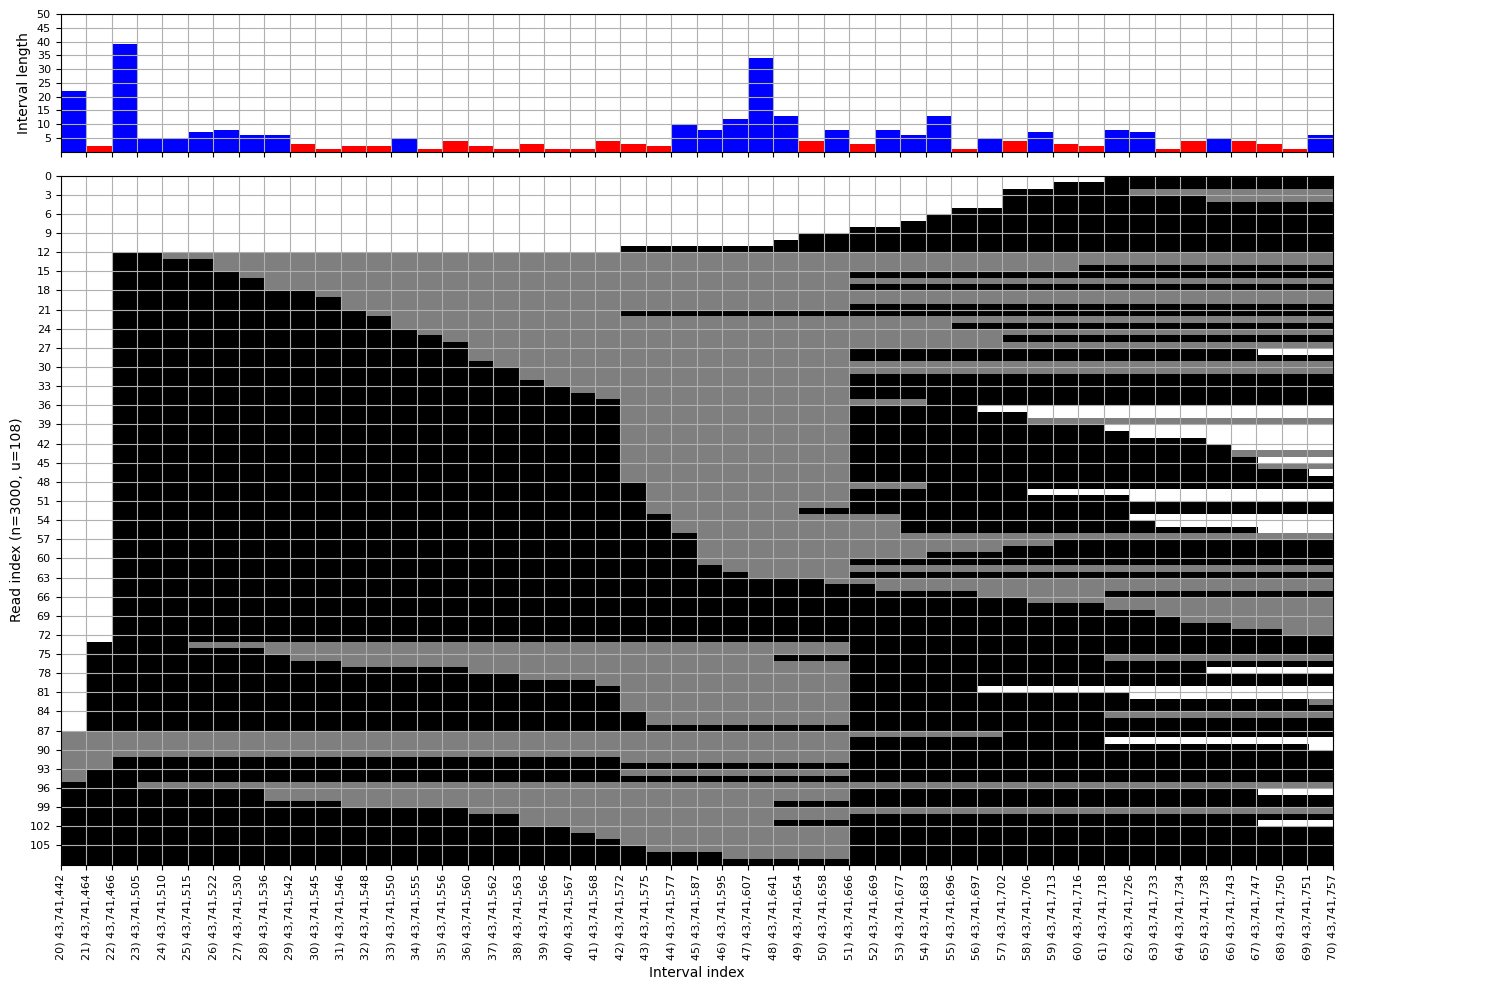

In [532]:
A = plot_large_intervals(pop_intervals(c_intervals[0], 0), 20, 70, unique=True)

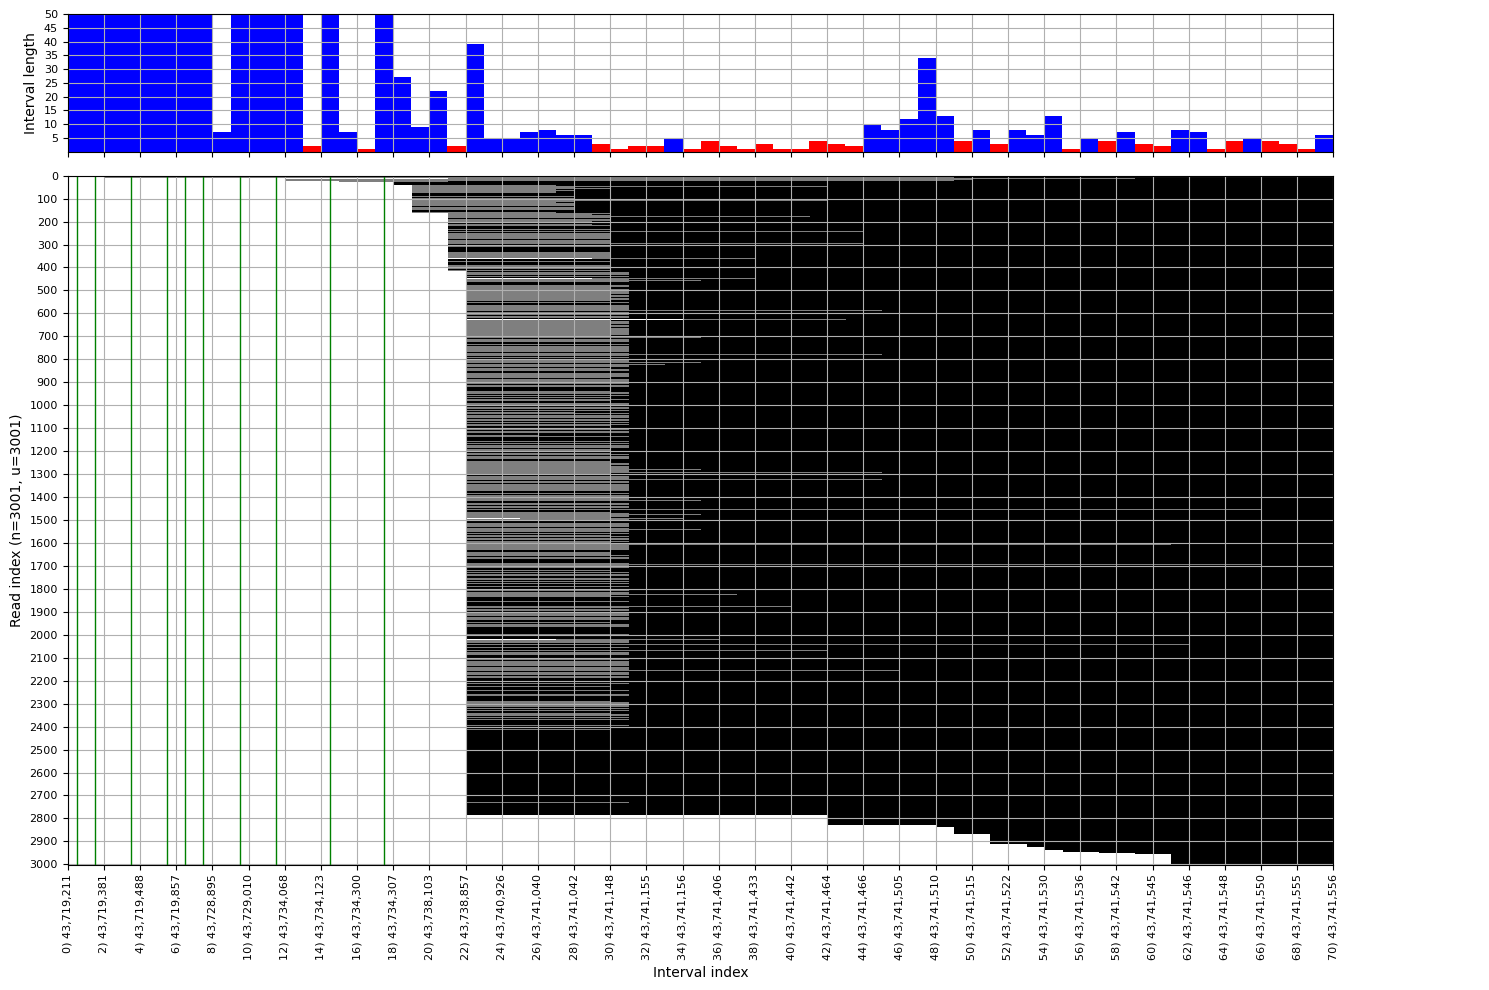

In [467]:
A = plot_large_intervals(pop_intervals(c_intervals[0], 0), 0, 70, unique=False)

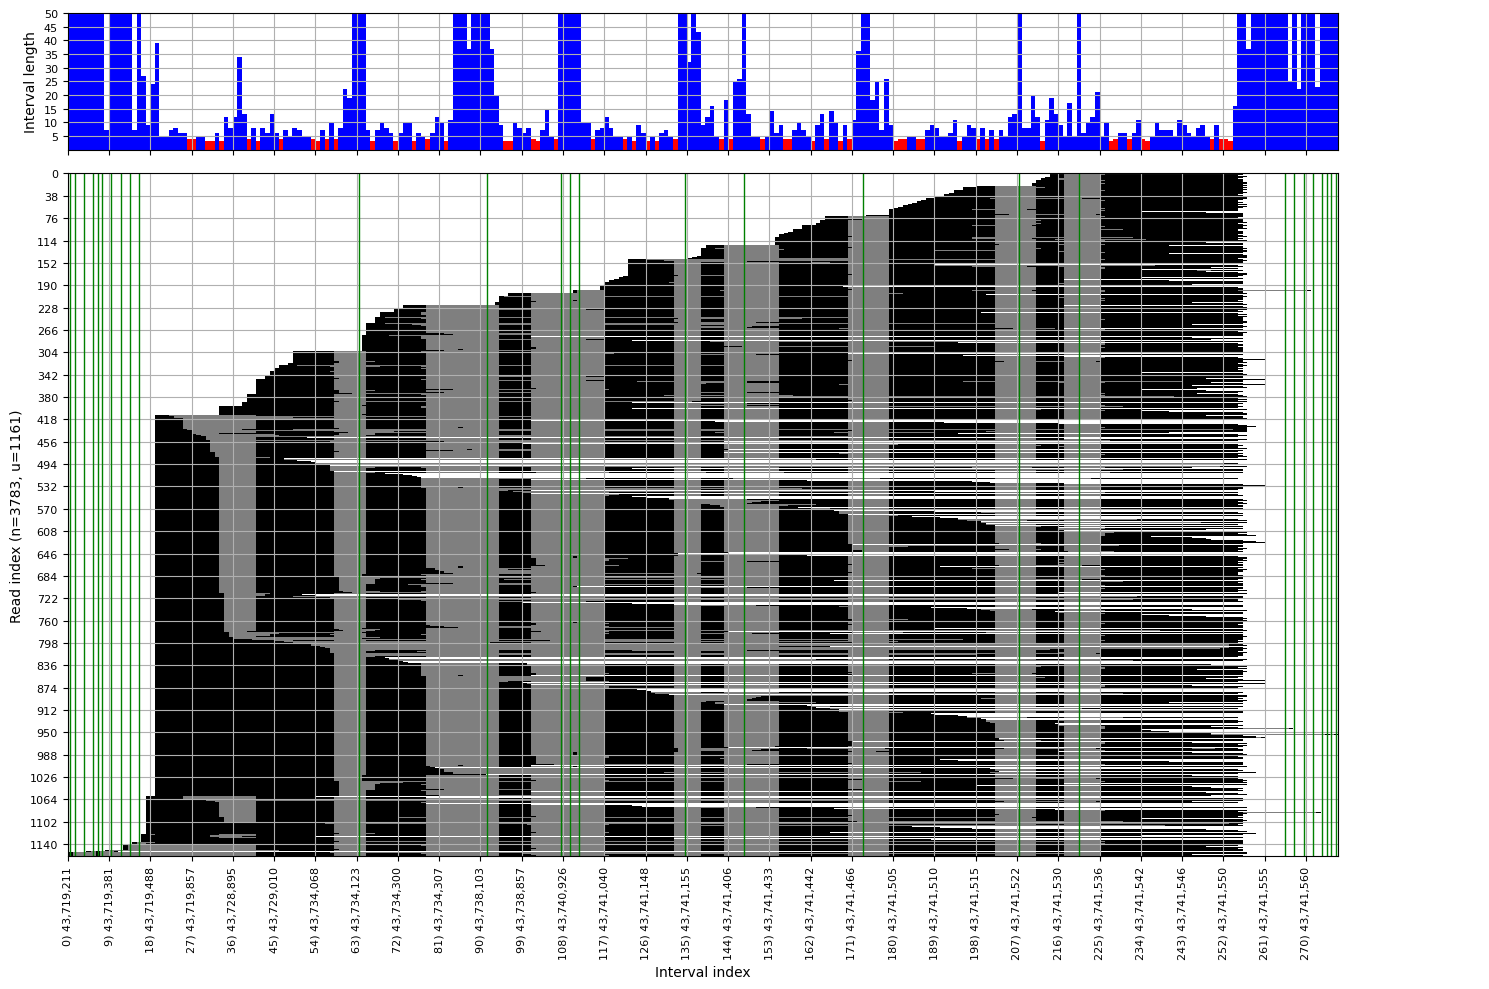

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1,  0,  0, ..., -1, -1, -1],
       [ 1,  0,  0, ..., -1, -1, -1],
       [ 1,  0,  0, ..., -1, -1, -1]], dtype=int8)

In [535]:
plot_large_intervals(X[3])


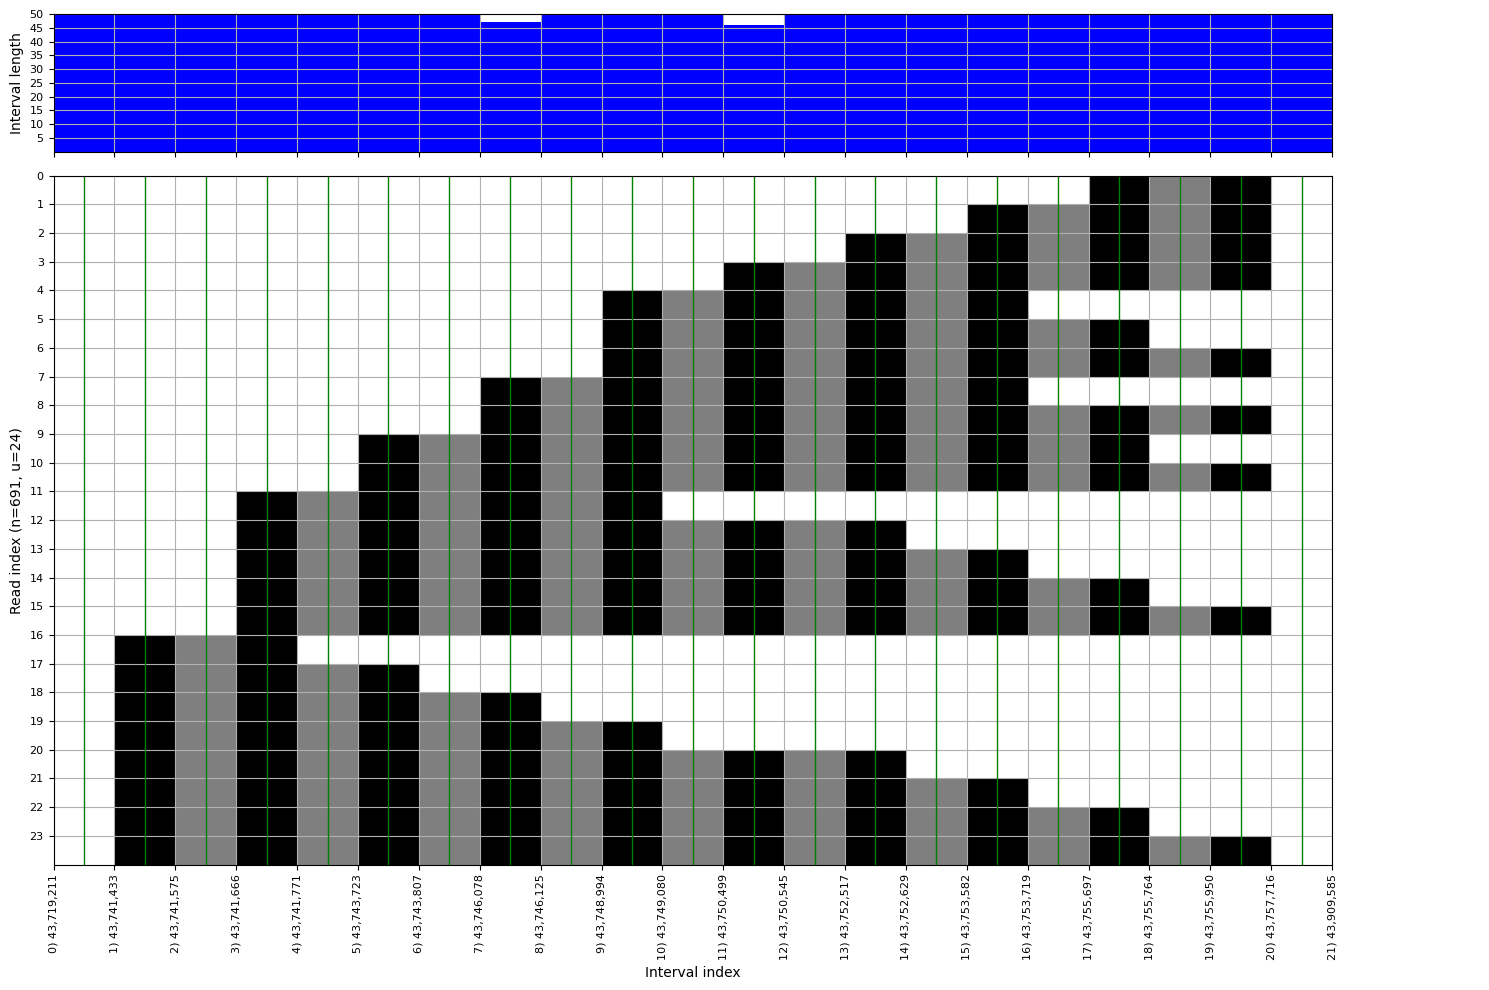

In [538]:
_ = plot_large_intervals(split_on_freq(X[3], .50)[1])


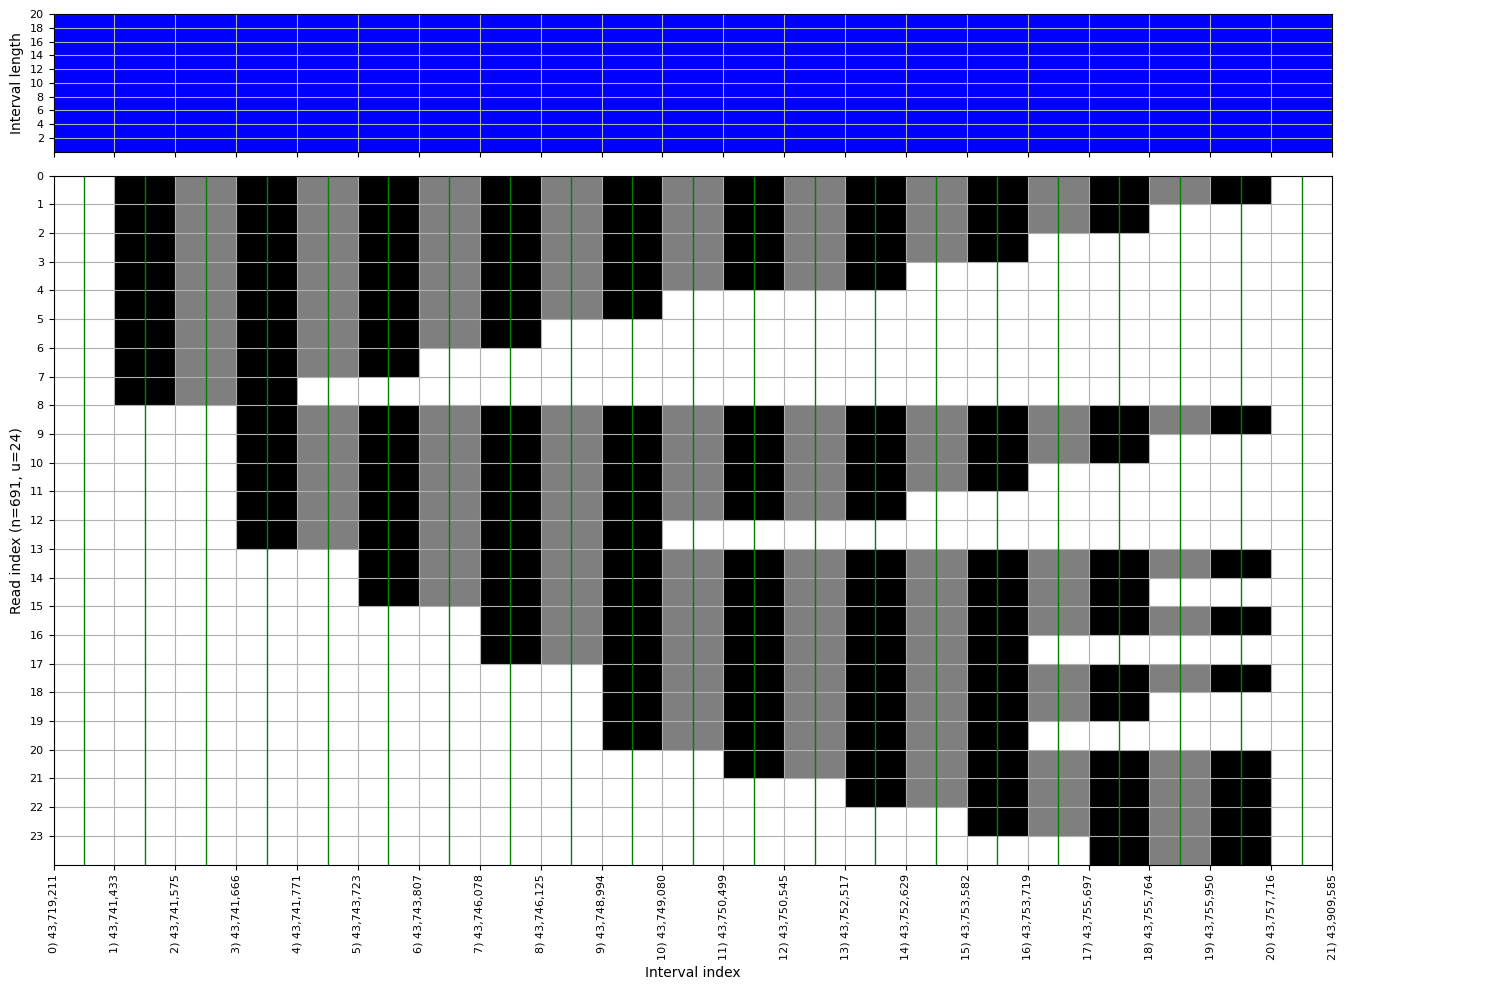

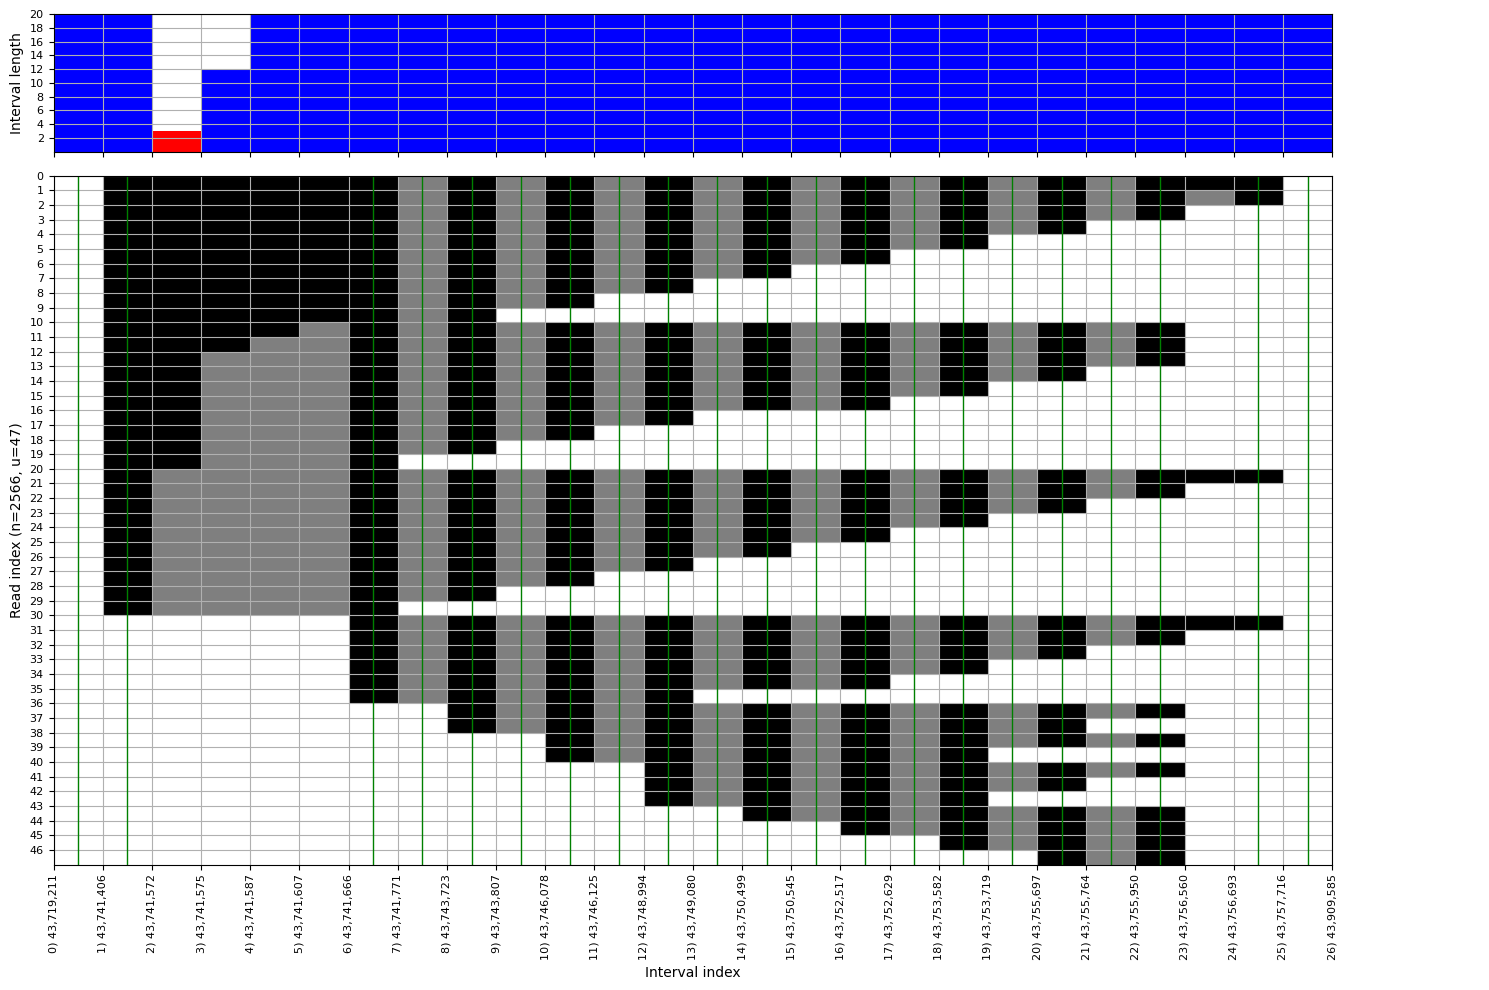

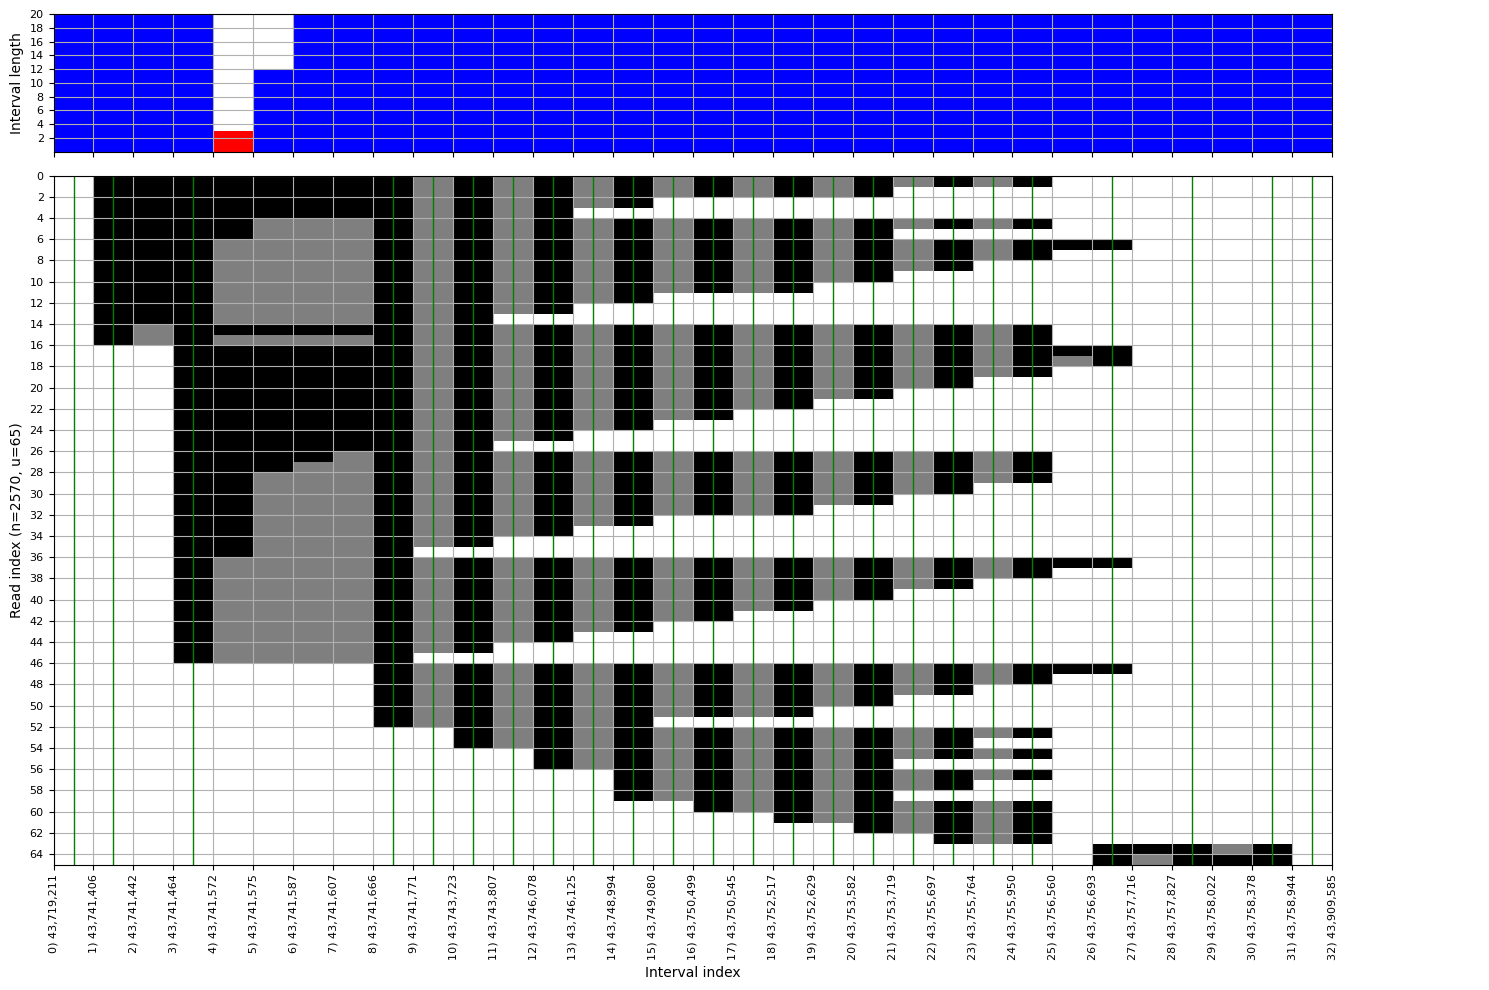

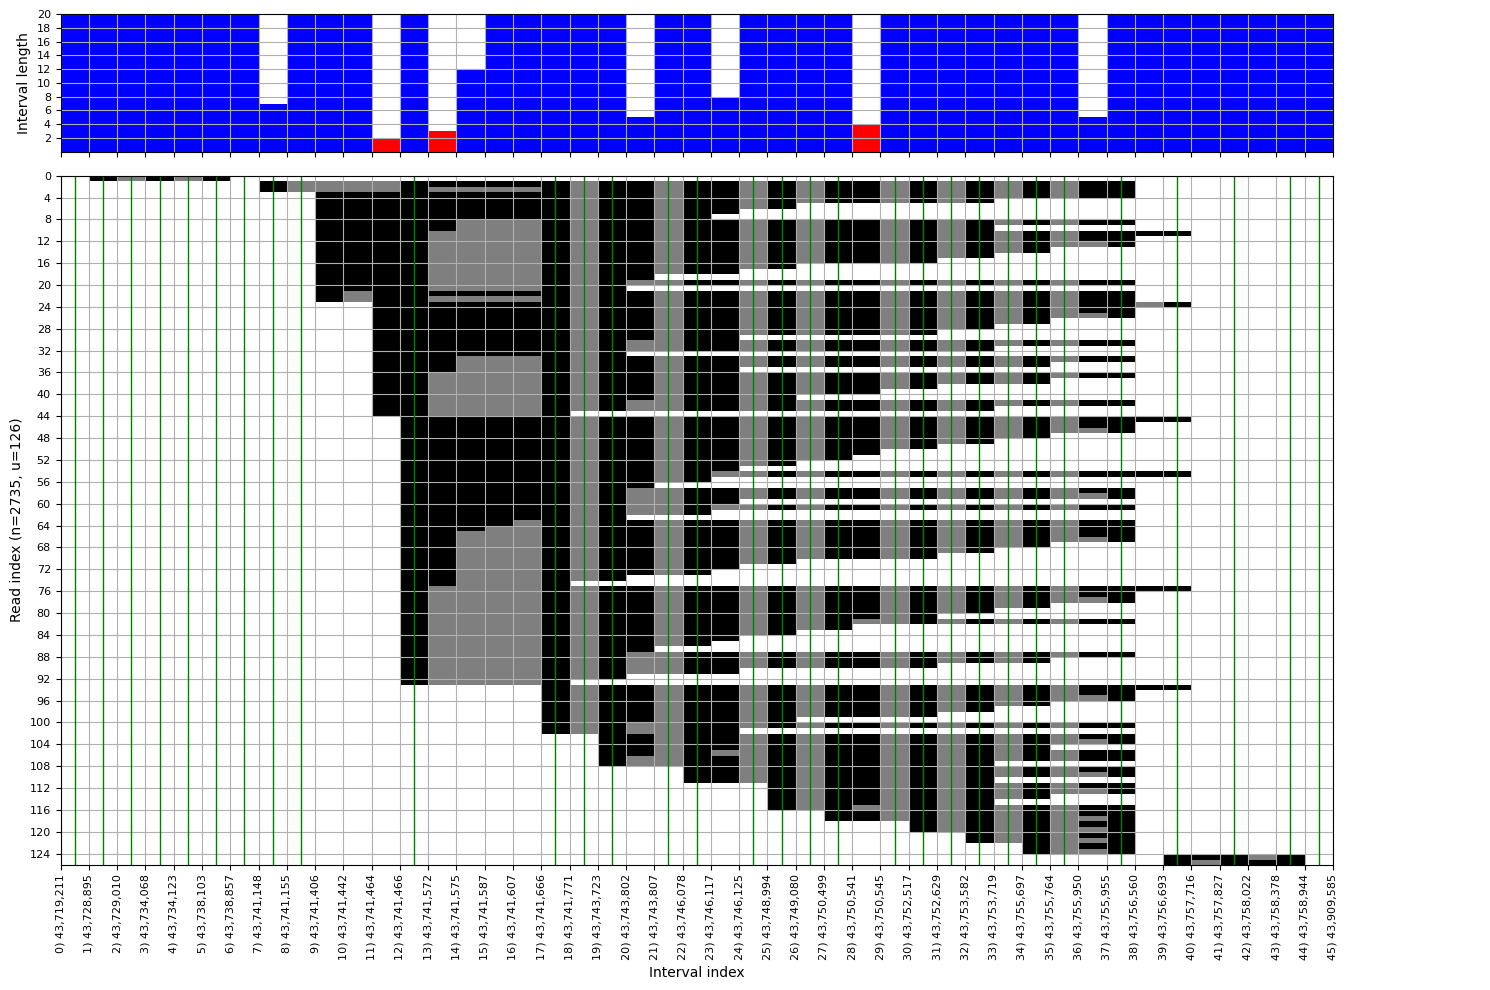

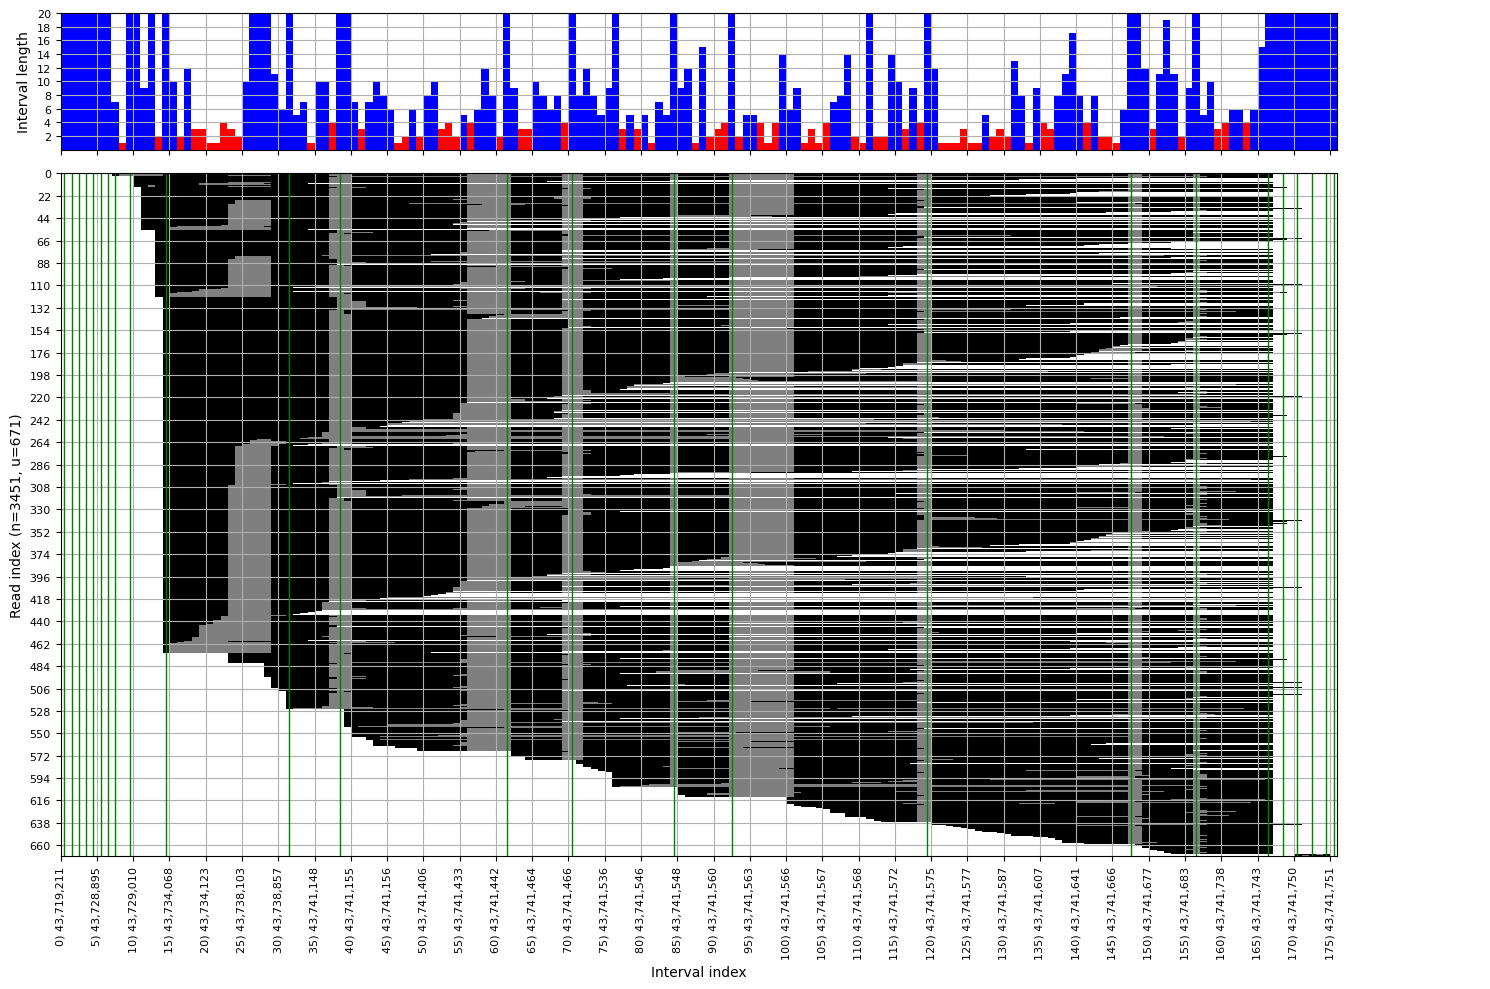

In [406]:
_ = plot_large_intervals(split_on_freq(X[1], 0.50)[1])
_ = plot_large_intervals(split_on_freq(X[1], 0.20)[1])
_ = plot_large_intervals(split_on_freq(X[1], 0.10)[1])
_ = plot_large_intervals(split_on_freq(X[1], 0.05)[1])
_ = plot_large_intervals(split_on_freq(X[1], 0.01)[1])

In [163]:
segment_tsvs = [f.replace("split", "segment") for f in split_tsvs]
old_intervals = list()
ambig_count = 0
for segment_tsv in segment_tsvs:
    if segment_tsv.endswith(".gz"):
        f = gzip.open(segment_tsv, "rt")
    else:
        f = open(segment_tsv, "r")
    segs = f.readline().strip("\n").split("\t")[2].split(",")
    segs = [int(s) for s in segs]
    intervals = [(s, e, set()) for s, e in zip(segs[:-1], segs[1:])]
    for l in f:
        l = l.rstrip("\n").split("\t")
        ridx = int(l[0])
        data = l[5]
        # first 1
        first = data.find("1")
        # last 1
        last = data.rfind("1")
        for i, d in enumerate(data[first : last + 1], first):
            if d == "1":
                intervals[i][2].add(ridx)
            elif d == "0":  # or d == "2":
                intervals[i][2].add(-ridx)
            ambig_count += d == "2"
    old_intervals.append(intervals)
    break

In [242]:
len(X[9])

174

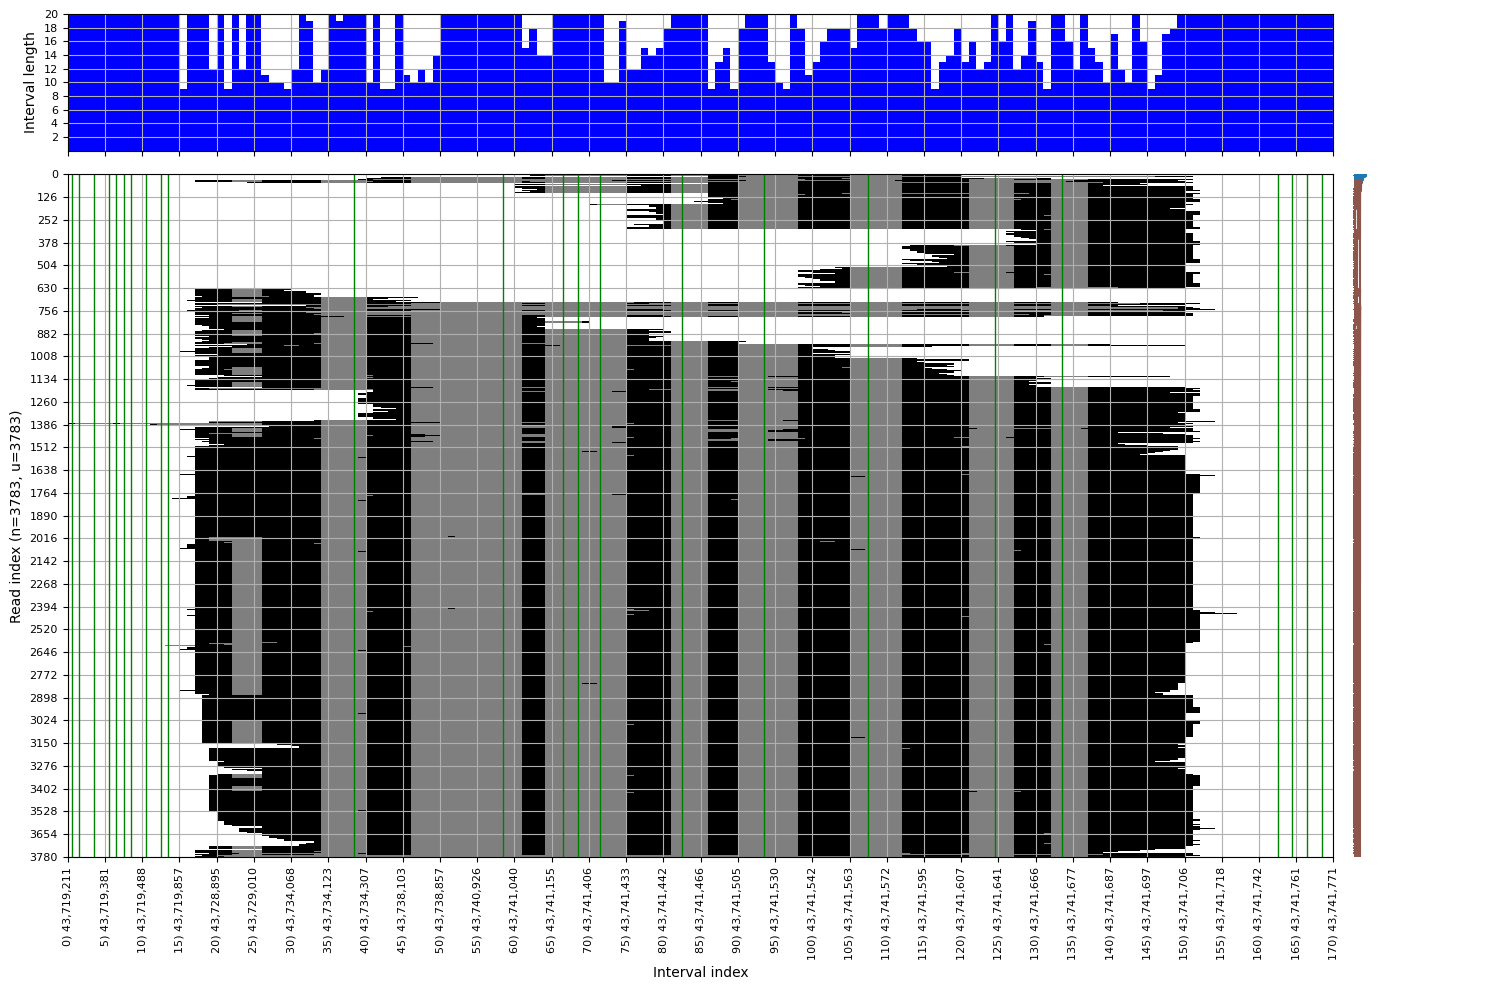

In [236]:
M = plot_large_intervals(X[9], unique=False)

In [273]:
def drop_low_freq(intervals, min_freq=0.01):
    low_freq_ridxs = set()
    for _, _, ridxs in intervals:
        counter = Counter((ridx > 0 for ridx in ridxs))
        if len(counter) == 1:
            continue
        if min(counter.values()) / len(ridxs) > min_freq:
            continue
        if counter[True] > counter[False]:
            min_key = False
        else:
            min_key = True
        low_freq_ridxs.update(ridx for ridx in ridxs if (ridx > 0) == min_key)
        low_freq_ridxs.update(-ridx for ridx in ridxs if (ridx > 0) == min_key)
    intervals = [(s, e, ridxs - low_freq_ridxs) for s, e, ridxs in intervals]
    intervals = compressed_intervals(merge_intervals(intervals))
    return intervals

In [302]:
def split_on_freq(intervals, min_freq=0.50):
    low_freq_ridxs = set()
    for _, _, ridxs in intervals:
        counter = Counter((ridx > 0 for ridx in ridxs))
        if len(counter) == 1:
            continue
        if min(counter.values()) / len(ridxs) > min_freq:
            continue
        if counter[True] > counter[False]:
            min_key = False
        else:
            min_key = True
        low_freq_ridxs.update(ridx for ridx in ridxs if (ridx > 0) == min_key)
        low_freq_ridxs.update(-ridx for ridx in ridxs if (ridx > 0) == min_key)
    h_intervals = [(s, e, ridxs - low_freq_ridxs) for s, e, ridxs in intervals]
    l_intervals = [(s, e, ridxs & low_freq_ridxs) for s, e, ridxs in intervals]
    h_intervals = get_compressed_intervals((0, h_intervals))[1]
    l_intervals = get_compressed_intervals((0, l_intervals))[1]
    return l_intervals,h_intervals

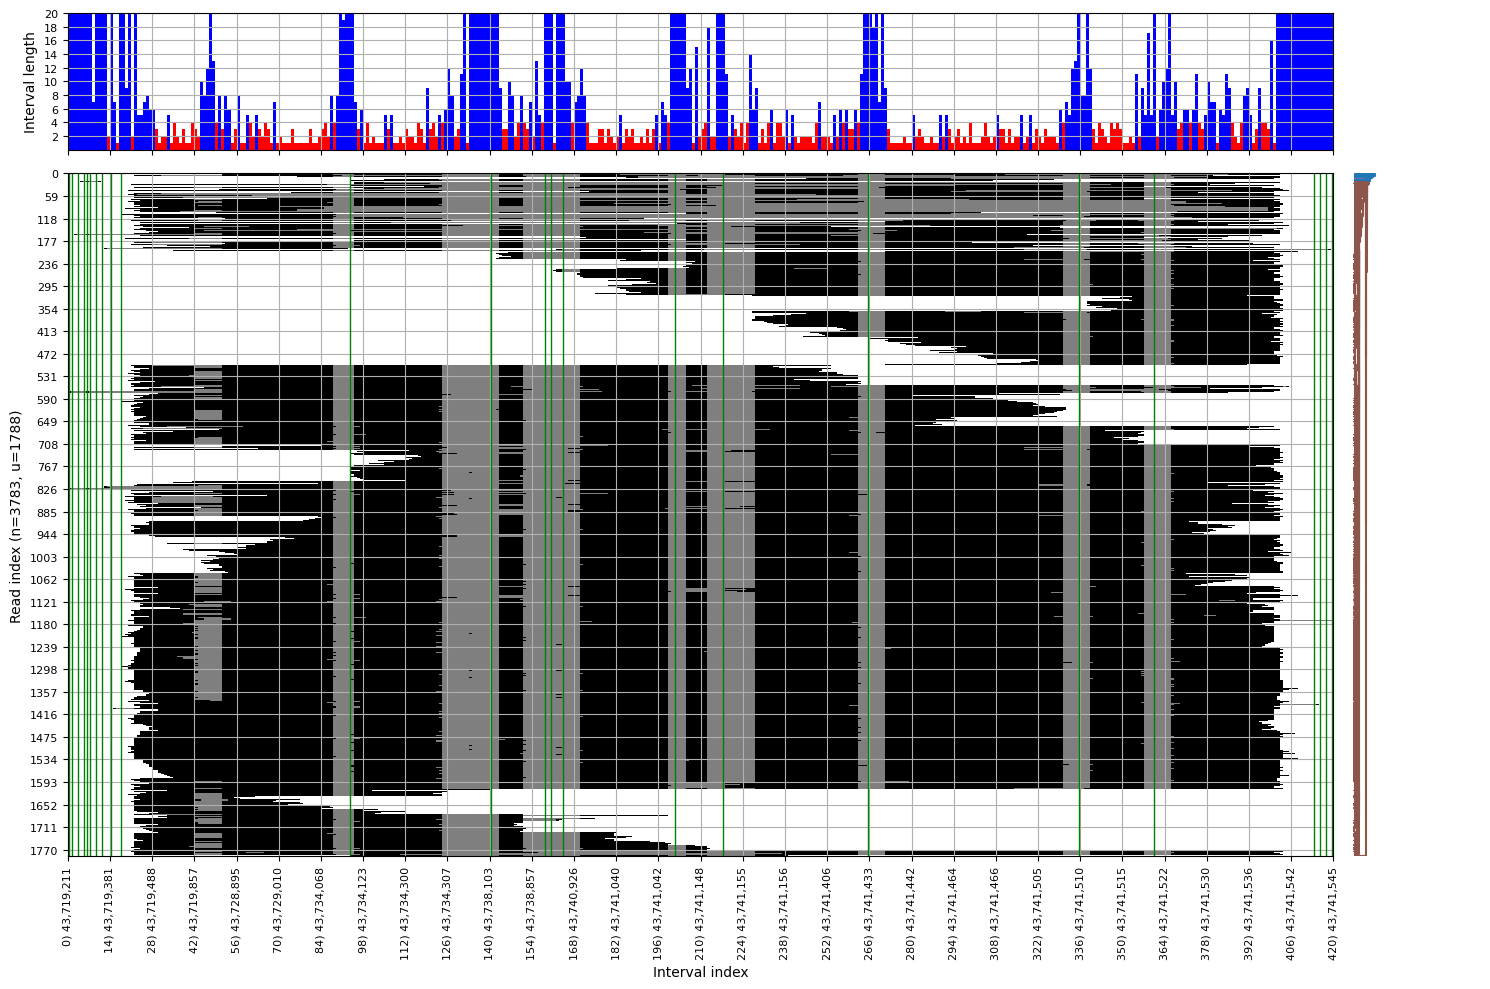

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

In [315]:
plot_large_intervals(X[1])

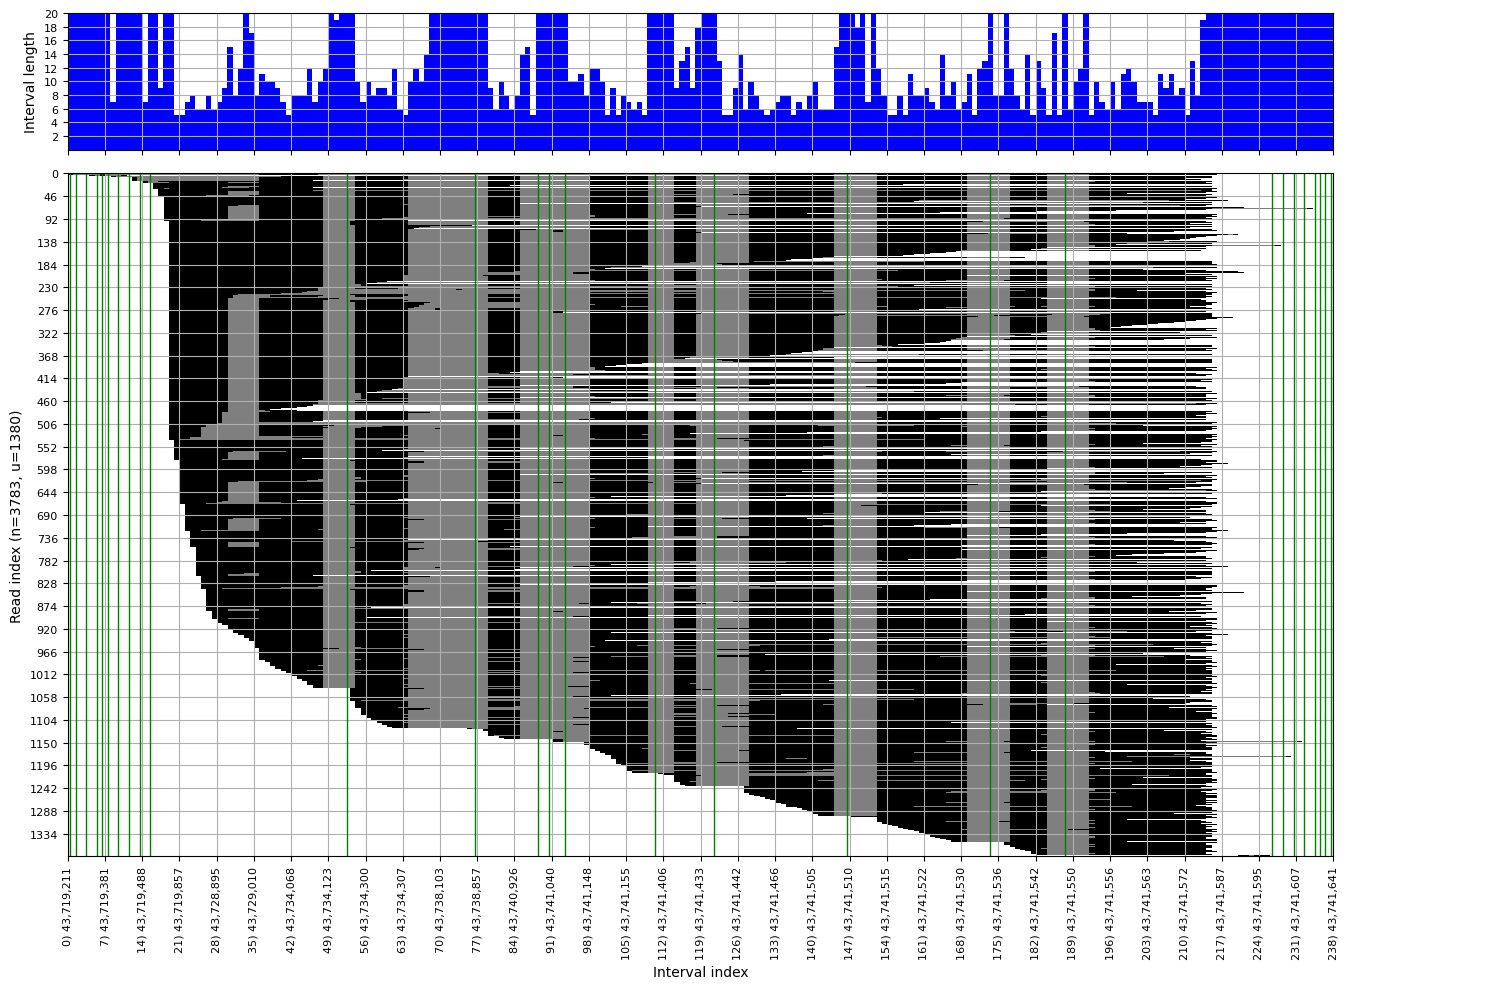

In [382]:
_ = plot_large_intervals(X[5])


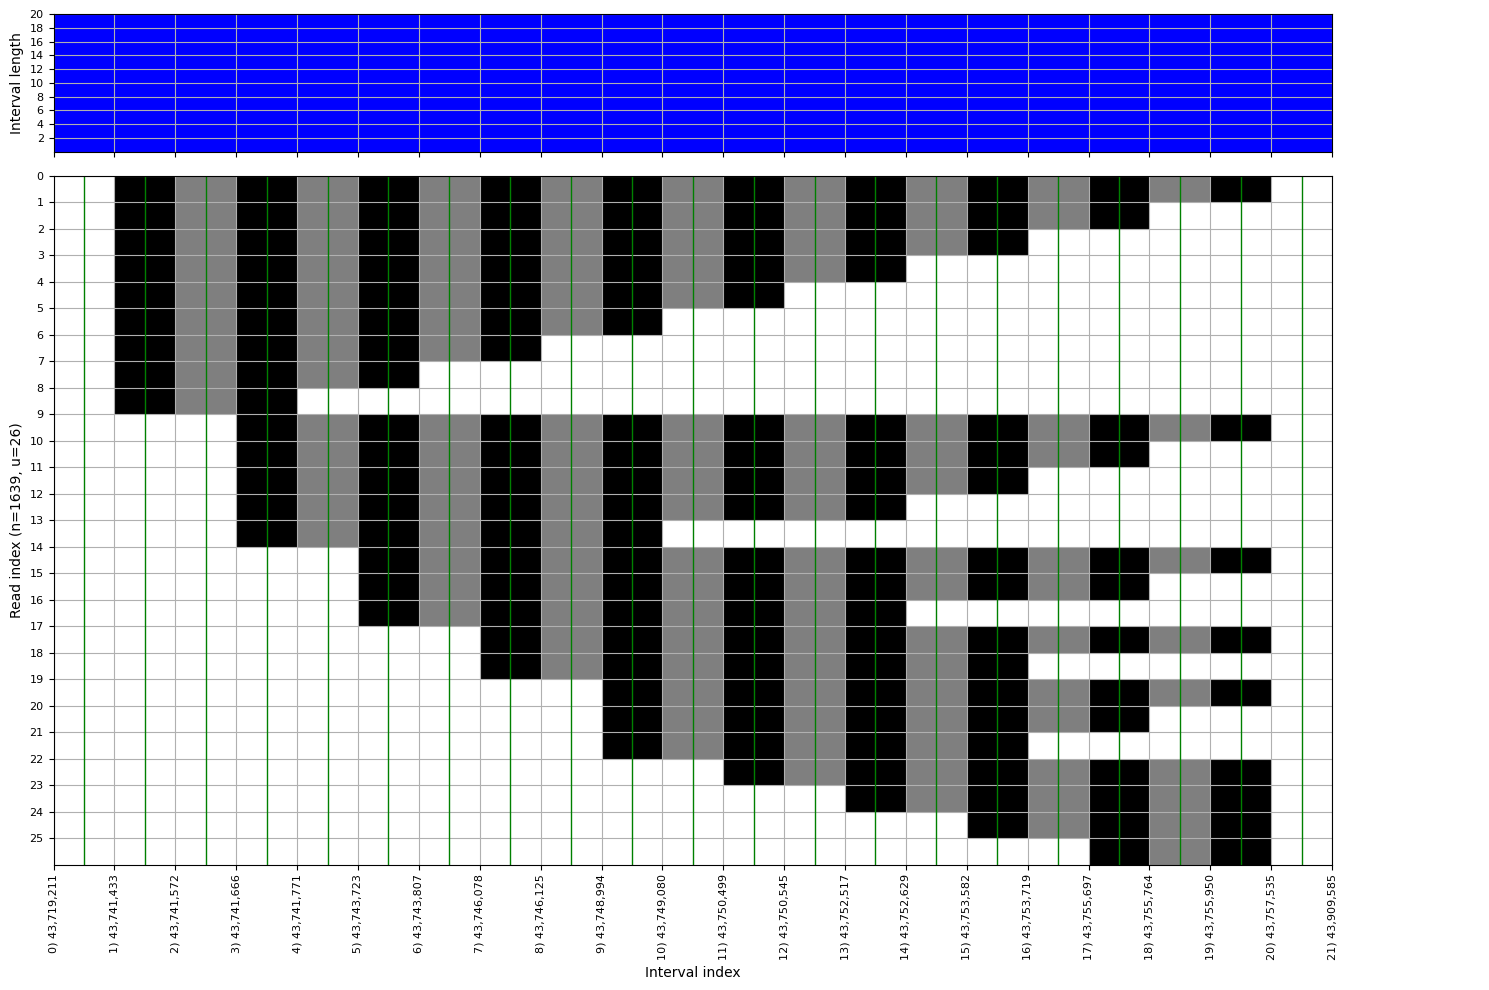

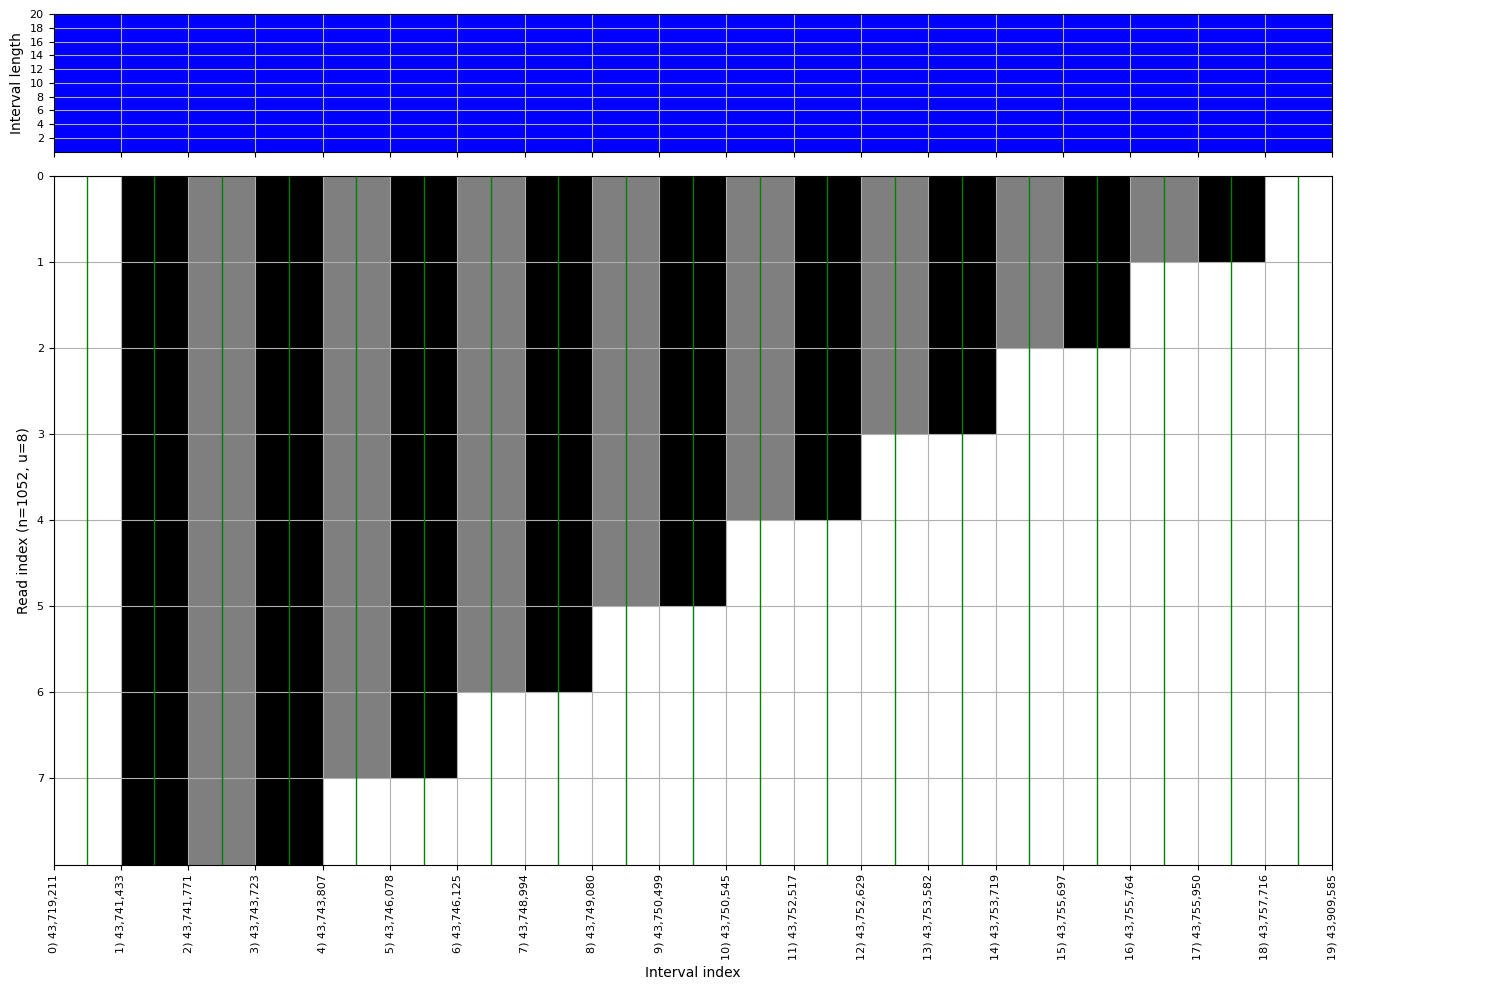

/tmp/ipykernel_82686/96371991.py:68: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  imshow_ax.imshow(matrix, cmap="binary", aspect="auto", interpolation="none")


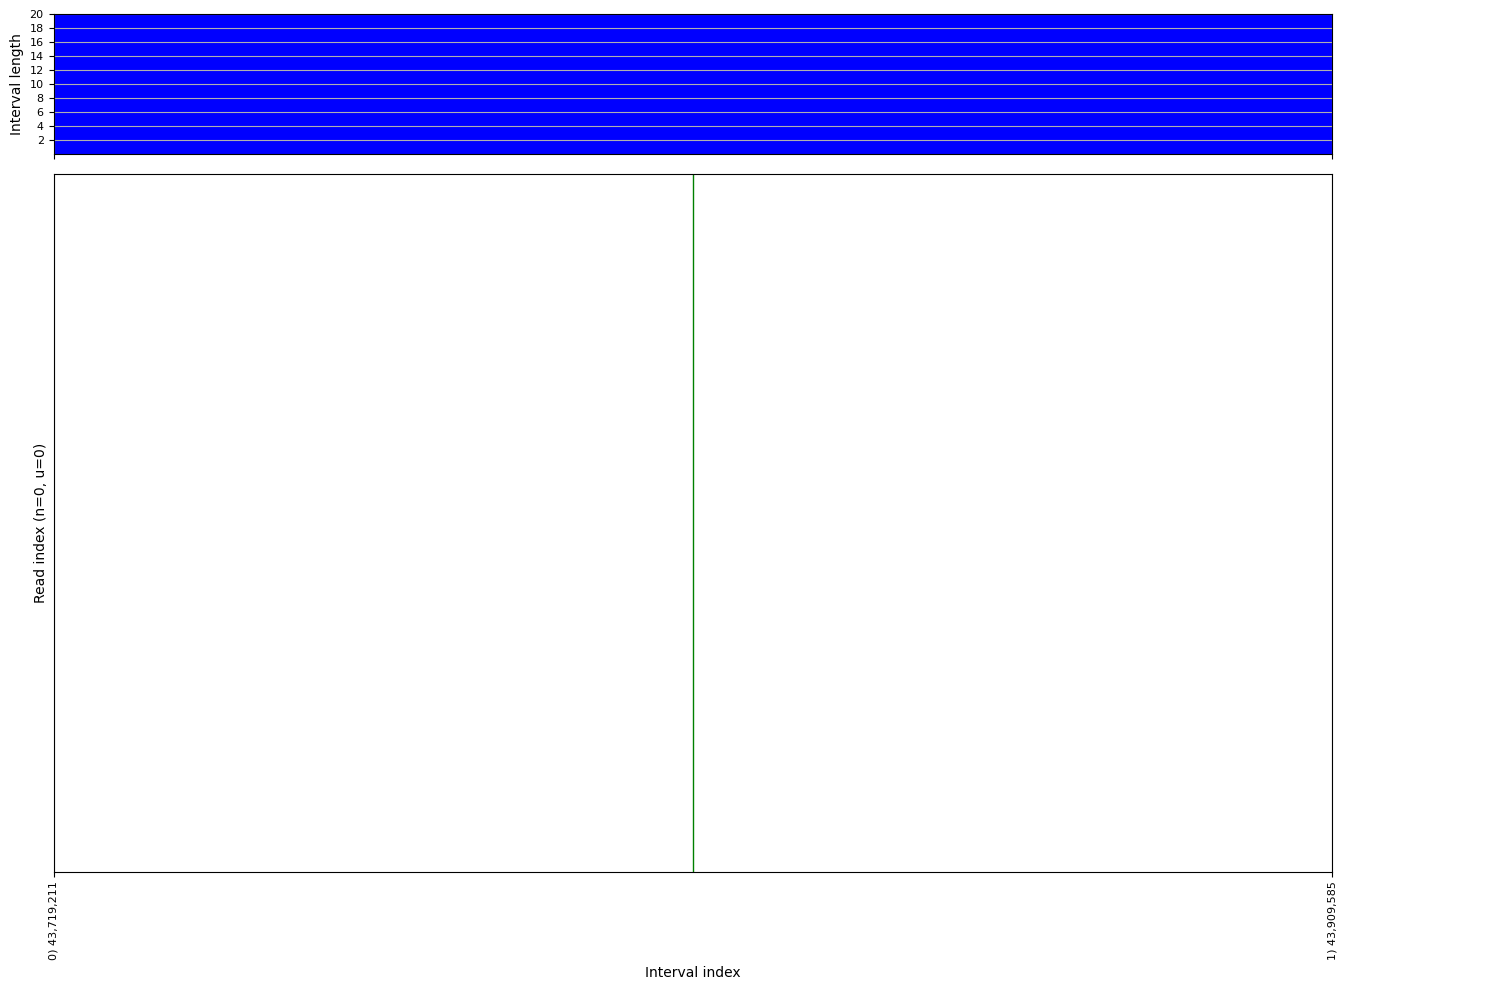

In [384]:
L  = X[5]
L, H = split_on_freq(L, min_freq=0.5)
_ = plot_large_intervals(H, )

L, H = split_on_freq(L, min_freq=0.5)
_ = plot_large_intervals(H, )

L, H = split_on_freq(L, min_freq=0.5)
_ = plot_large_intervals(H, )


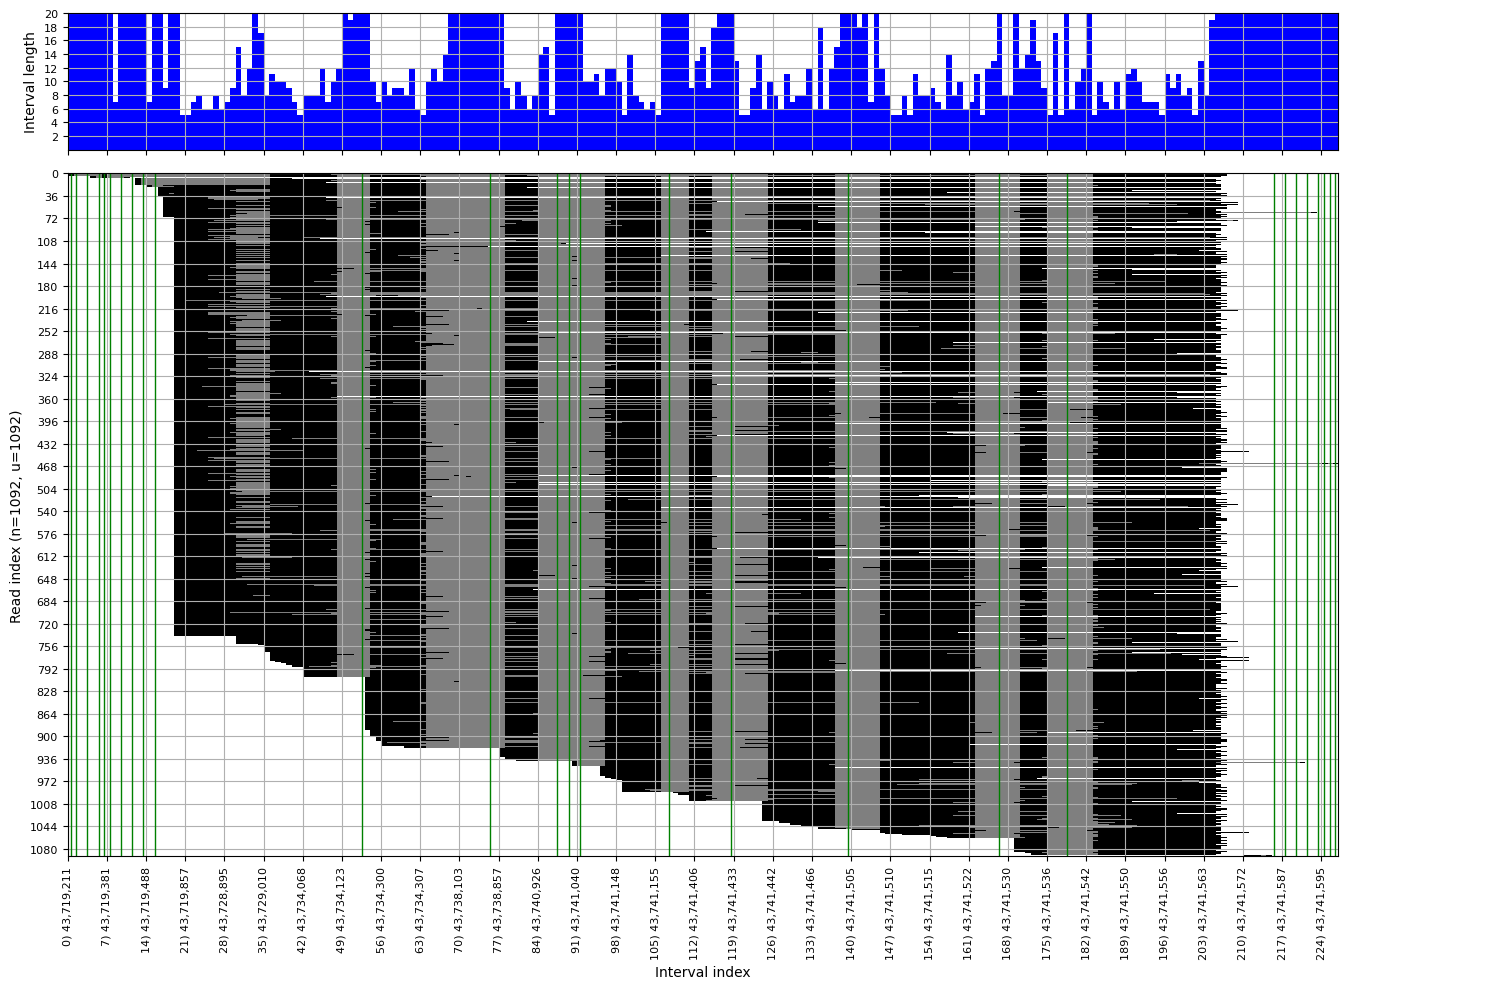

In [397]:
_ = plot_large_intervals(L,unique=False)

In [356]:
for x in X:
    print(len(x))
    for i, (s, e, ridxs) in enumerate(x):
        f1 = 22 in ridxs
        f2 = -22 in ridxs
        assert not (f1 and f2)
        if (f1 or f2):
            print(i, s, e, f1, f2)
            break

1125
29 43741148 43741155 True False
425
15 43741148 43741155 True False
355
15 43741148 43741155 True False
307
14 43741148 43741155 True False
273
14 43741148 43741155 True False
238
14 43741148 43741155 True False
219
14 43741148 43741155 True False
203
14 43741148 43741155 True False
193
13 43741155 43741406 False True
174
13 43741155 43741406 False True


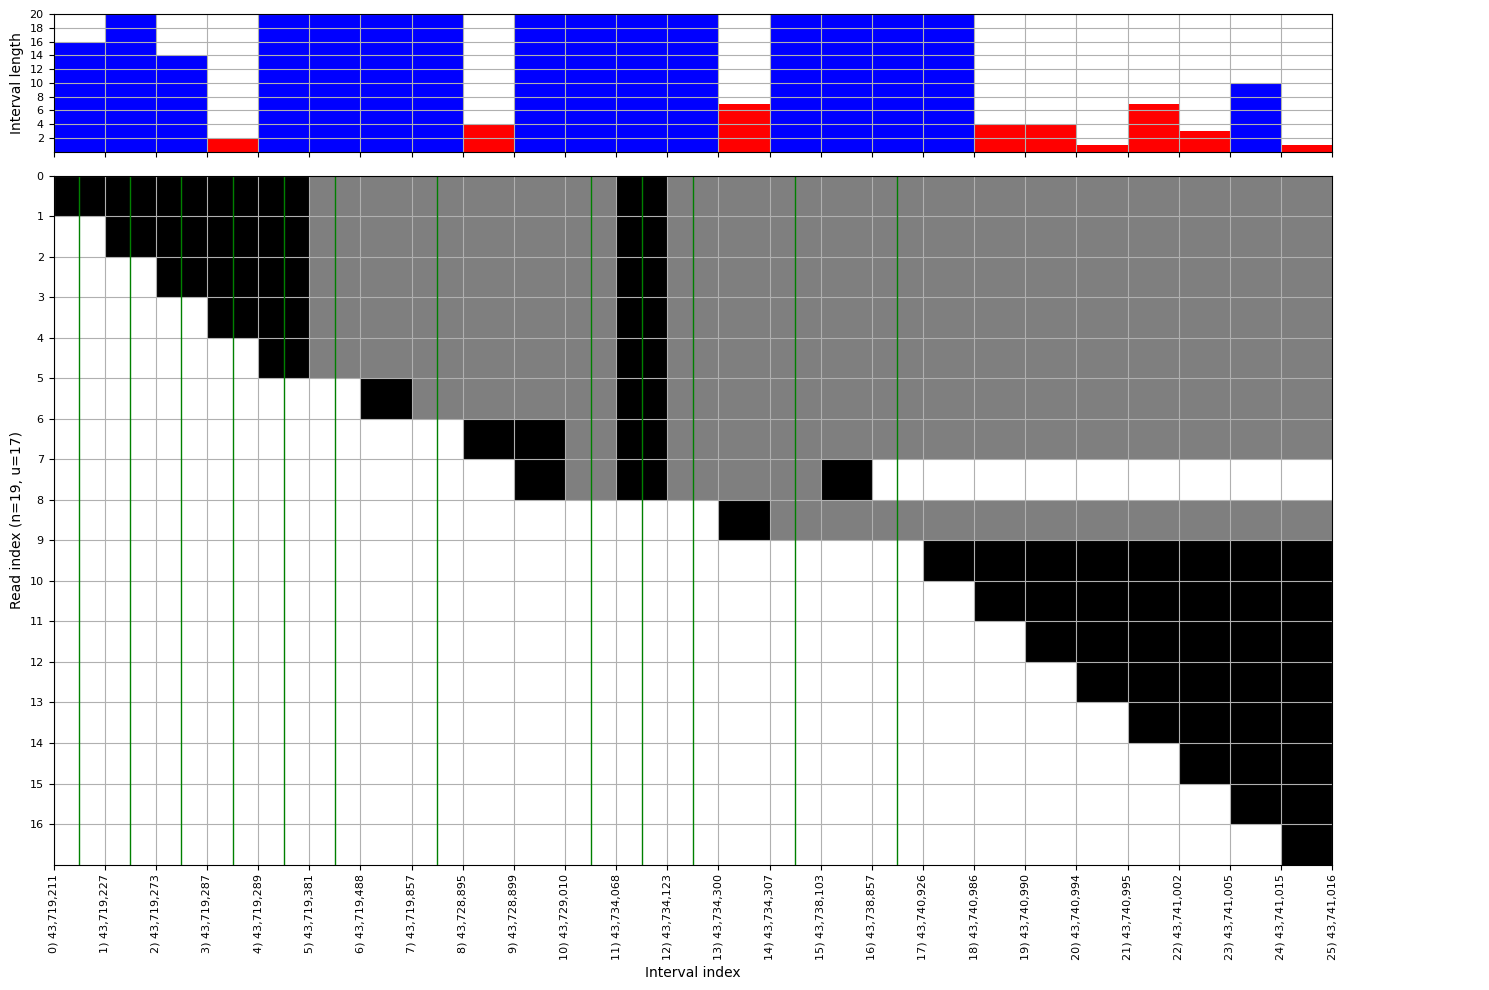

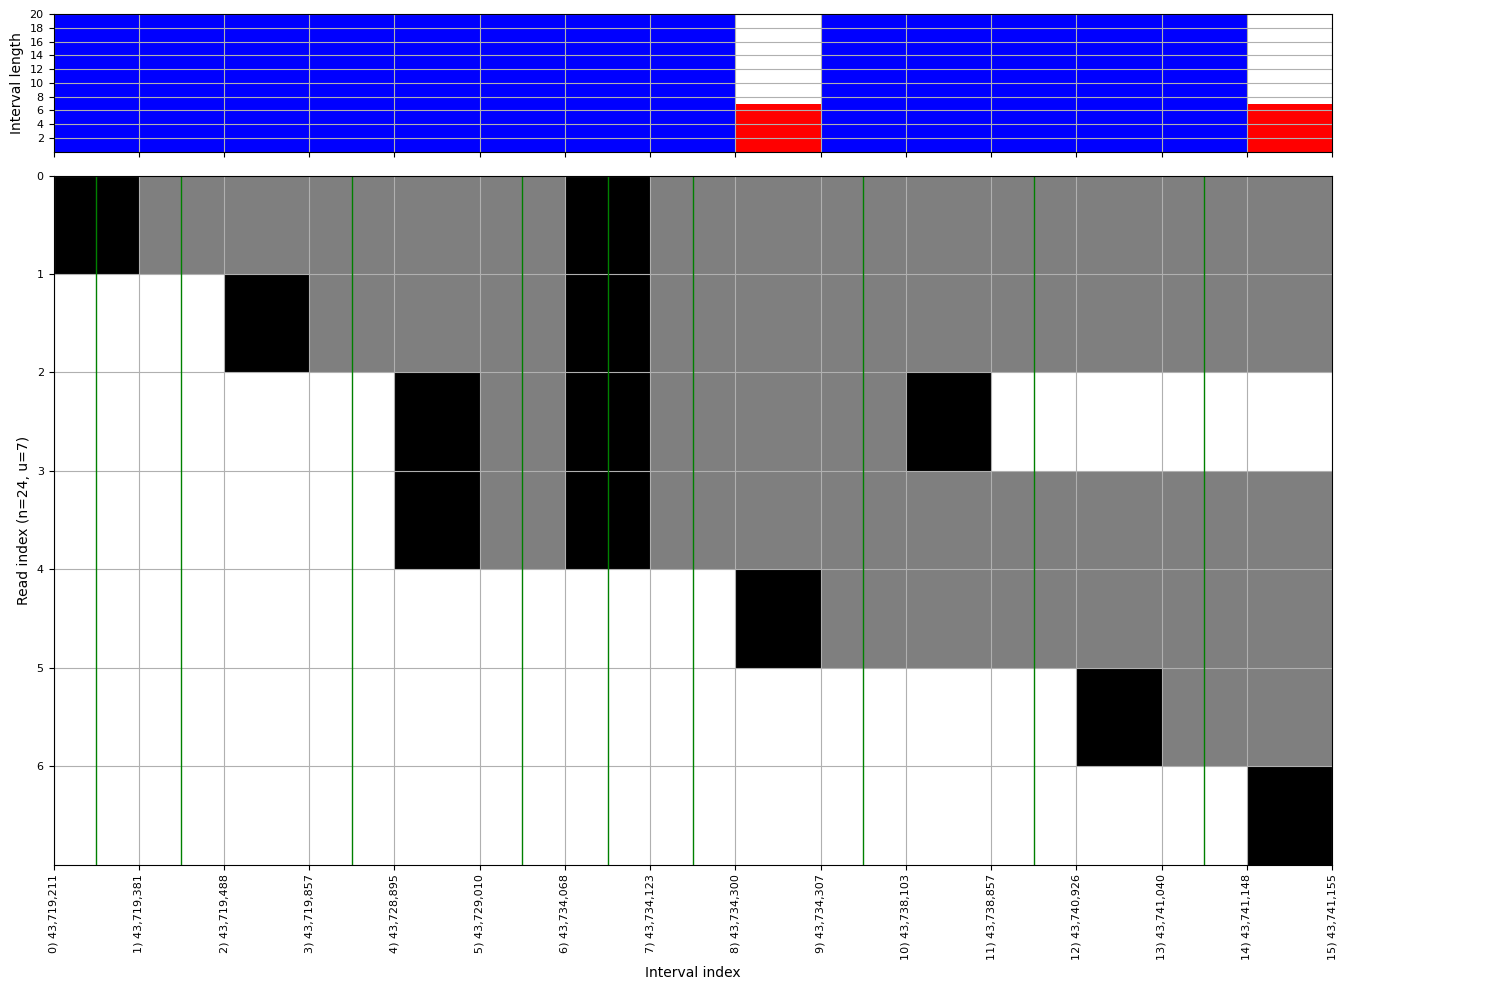

array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  1,  0,  1,  0,  0,  0,  1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1,  1,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1]],
      dtype=int8)

In [369]:
plot_large_intervals(X[0], 0, 25, min_height=10)
plot_large_intervals(X[7], 0, 15, min_height=10)

In [341]:
L, H = split_on_freq(L, min_freq=0.05)
print()
print(len(L), len(H))
_ = plot_large_intervals(H)
_ = plot_large_intervals(L)


ValueError: min() arg is an empty sequence

In [342]:
L

[(43719211, 43728895, set()),
 (43728895, 43729010, {9}),
 (43729010, 43734068, {-9}),
 (43734068, 43734123, {9}),
 (43734123, 43738103, {-9}),
 (43738103, 43738857, {9}),
 (43738857, 43740926, set()),
 (43740926, 43741040, {15}),
 (43741040, 43741406, {-15}),
 (43741406,
  43741530,
  {-15,
   55,
   60,
   68,
   88,
   106,
   129,
   140,
   157,
   166,
   176,
   220,
   253,
   258,
   278,
   288,
   309,
   318,
   319,
   366,
   367,
   415,
   456,
   457,
   472,
   548,
   562,
   565,
   570,
   591,
   610,
   611,
   614,
   618,
   688,
   750,
   766,
   780,
   781,
   783,
   831,
   833,
   834,
   892,
   902,
   907,
   918,
   920,
   936,
   994,
   1019,
   1039,
   1061,
   1107,
   1114,
   1131,
   1196,
   1228,
   1267,
   1300,
   1311,
   1321,
   1339,
   1349,
   1361,
   1392,
   1412,
   1413,
   1428,
   1476,
   1478,
   1491,
   1510,
   1545,
   1575,
   1579,
   1615,
   1618,
   1630,
   1636,
   1643,
   1669,
   1670,
   1675,
   1681,
   1

In [272]:
print(f"{'#'.ljust(13)}{'-1'.ljust(17)}{'1'.ljust(17)}")

for i in range(M.shape[1]):
    L = X[9][i][1] - X[9][i][0]
    C = Counter({k: v for k, v in zip(*np.unique(M[:,i], return_counts=True)) if k != 0})
    T = sum(C.values())
    max_val = max(C.values())
    if max_val/T < .99 or max_val == T:
        continue
    print(f"{i:3d} ({L:3d}) {T:5d} ", end="")
    for x in [-1, 1]:
        print(f"{C[x]:5d} {C[x]/T:5.0%}", end="\t")
    print()
    # print()

#            -1               1                
  0 (170)  3783  3777  100%	    6    0%	
  2 (369)  3777  3776  100%	    1    0%	
  4 (115)  3776  3774  100%	    2    0%	
  6 ( 55)  3783  3774  100%	    9    0%	
  9 (754)  3774  3773  100%	    1    0%	
 11 (114)  3774  3763  100%	   11    0%	
 14 ( 27)  3760  3744  100%	   16    0%	
 34 ( 12)   834   826   99%	    8    1%	
 35 ( 22)   830   826  100%	    4    0%	
 36 ( 19)   829   826  100%	    3    0%	
 37 (335)   827   826  100%	    1    0%	
 50 ( 85)   675   672  100%	    3    0%	
 52 (533)   674   672  100%	    2    0%	
 53 ( 37)   675   672  100%	    3    0%	
 54 (213)   674   672  100%	    2    0%	
 55 (107)   675   672  100%	    3    0%	
 56 (149)   674   672  100%	    2    0%	
 57 (142)   674   672  100%	    2    0%	
 59 ( 37)   674   673  100%	    1    0%	
 64 ( 14)   695   690   99%	    5    1%	
 65 ( 20)   693   690  100%	    3    0%	
 67 (153)   691   690  100%	    1    0%	
 72 ( 10)   689   688  100%	    1    0%	
 81 ( 75)

In [ ]:
min_len_intervals = list()
for l in range(1, 10):


1	12785	1.20	0.91	1	1	27	11
2	16289	2.22	0.82	2	2	14	10
3	12194	3.30	1.14	3	3	21	12
4	18516	4.27	1.14	4	4	24	16
5	9228	5.31	1.37	5	5	25	15
6	9507	6.41	1.68	6	6	24	18
7	8248	7.29	1.50	7	7	28	21
8	7555	8.36	1.79	8	8	32	24
9	7139	9.37	1.91	9	9	27	27


Type	Mean	Std	Median	Min	Max
Cmprss	57	84	26	3	2390
Popped	53	77	25	3	2129
Old	35	39	20	2	519
Min 2	50	76	22	2	2119
Min 3	48	76	19	0	2119
Min 4	45	76	17	0	2117


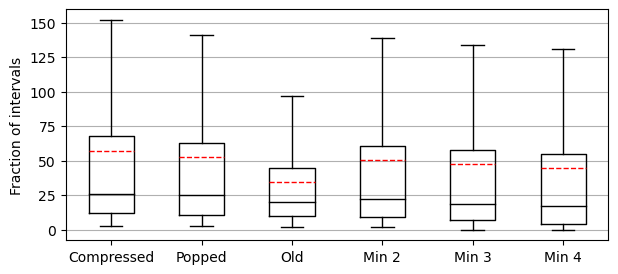

In [13]:
MIN_VALS = list(range(2, 5))
columns = [list() for _ in range(3 + len(MIN_VALS))]
for idx in range(len(c_intervals)):
    denominator = 1  # / len(c_intervals[idx])
    columns[0].append(len(compressed_c_intervals[idx]) * denominator)
    columns[1].append(len(popped_intervals[idx]) * denominator)
    columns[2].append(old_segmentation_lens[idx] * denominator)
    for IDX, min_val in enumerate(MIN_VALS, start=3):
        columns[IDX].append(
            len([_ for _, _, ridxs in popped_intervals[idx] if len(ridxs) >= min_val])
            * denominator
        )
print("Type", "Mean", "Std", "Median", "Min", "Max", sep="\t")
for c, l in zip(
    columns, ["Cmprss", "Popped", "Old"] + [f"Min {min_val}" for min_val in MIN_VALS]
):
    print(
        l,
        f"{np.mean(c):.0f}",
        f"{np.std(c):.0f}",
        f"{np.median(c):.0f}",
        f"{np.min(c):.0f}",
        f"{np.max(c):.0f}",
        sep="\t",
    )
fig, ax = plt.subplots(figsize=(4 + len(MIN_VALS), 3))
ax.boxplot(
    columns,
    labels=["Compressed", "Popped", "Old"] + [f"Min {min_val}" for min_val in MIN_VALS],
    showfliers=False,
    showmeans=True,
    meanline=True,
    medianprops={"color": "black"},
    meanprops={"color": "red"},
)
# ax.set_ylim(0, 1)
ax.set_ylabel("Fraction of intervals", size=10)
# ax.tick_params(axis="both", which="both", labelsize=8)
# ax.set_yticks(np.arange(0, 1 + 0.1, 0.1))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.grid(which="major", axis="y")
plt.show()

In [14]:
min_len = 5
min_read = 5
print(
    "Type",
    "Count".rjust(9),
    "%".rjust(4),
    f"l>={min_len}",
    f"|R|>={min_read}",
    sep="\t",
)
for X, label in zip(
    [c_intervals, compressed_c_intervals, popped_intervals],
    ["Orig", "Cmprss", "Popped"],
):
    counter = Counter()
    for idx, intervals in enumerate(X):
        for s, e, ridxs in intervals:
            l = e - s
            counter[(l >= min_len, len(ridxs) >= min_read)] += 1
    total = sum(counter.values())
    for k in ((True, True), (True, False), (False, True), (False, False)):
        v = counter[k]
        print(
            label, f"{v:,}".rjust(9), f"{v/total:.0%}".rjust(4), *map(str, k), sep="\t"
        )
    print(
        label,
        f"{total:,}".rjust(9),
        f"{total/total:.0%}".rjust(4),
        "NA",
        "NA",
        sep="\t",
    )

Type	    Count	   %	l>=5	|R|>=5
Orig	  663,934	 48%	True	True
Orig	  146,197	 11%	True	False
Orig	  544,581	 40%	False	True
Orig	   17,967	  1%	False	False
Orig	1,372,679	100%	NA	NA
Cmprss	  409,120	 71%	True	True
Cmprss	  102,395	 18%	True	False
Cmprss	   66,229	 11%	False	True
Cmprss	    2,020	  0%	False	False
Cmprss	  579,764	100%	NA	NA
Popped	  409,105	 76%	True	True
Popped	  102,390	 19%	True	False
Popped	   27,995	  5%	False	True
Popped	       67	  0%	False	False
Popped	  539,557	100%	NA	NA


In [ ]:
def get_too_small(lengths, min_len):
    return

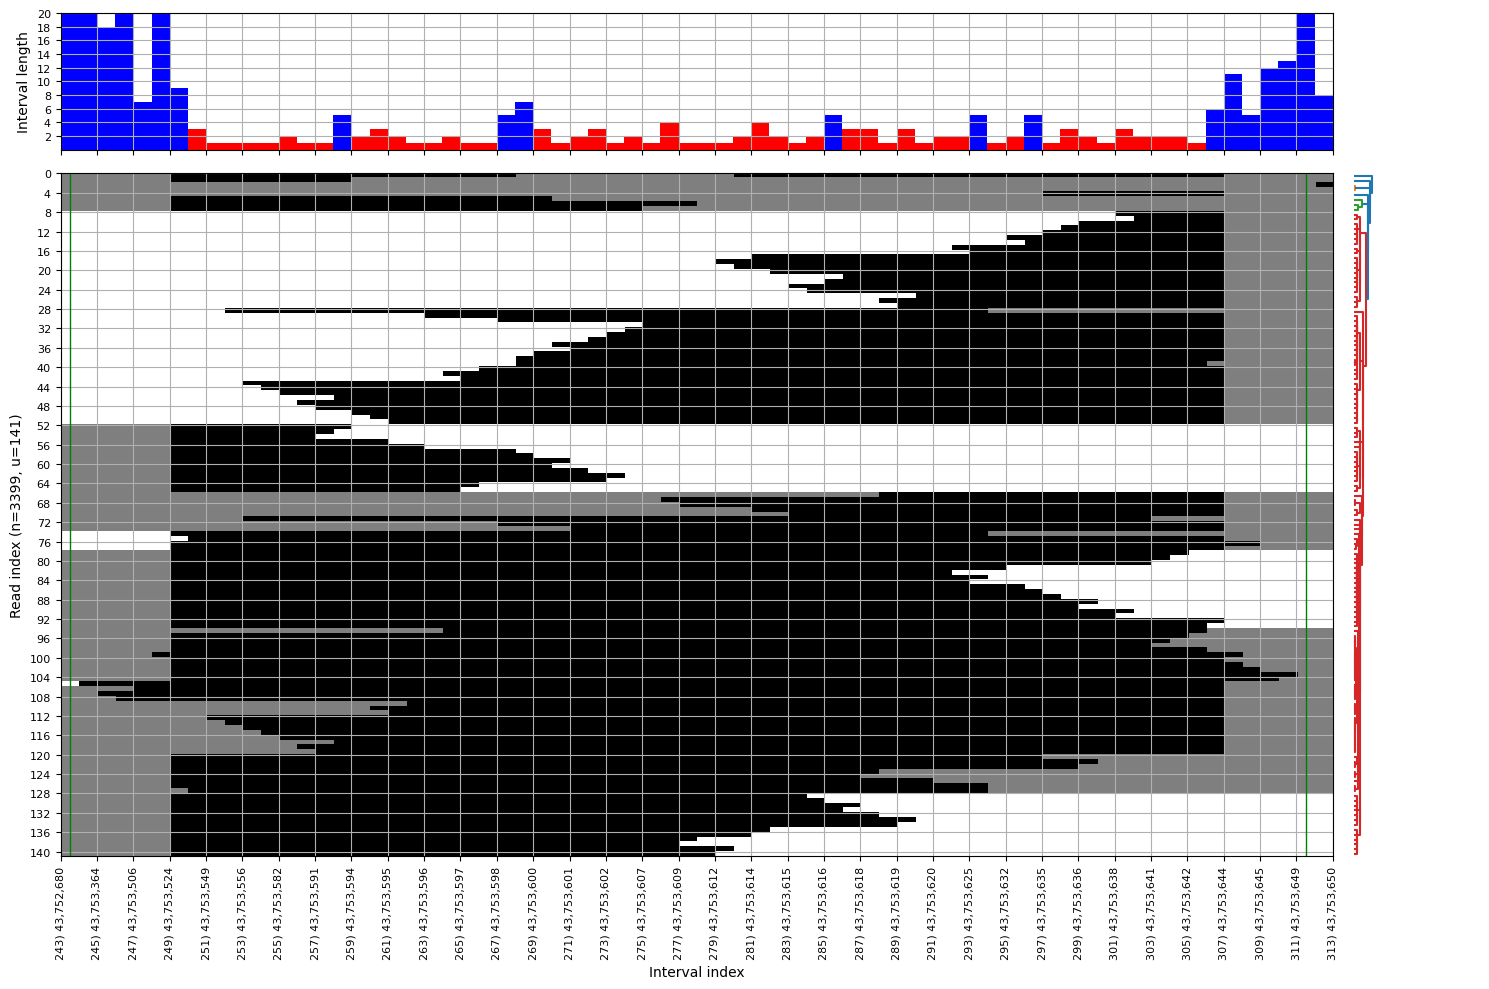

In [43]:
M = plot_large_intervals(popped_intervals[0], 243, 313, unique=True)

In [69]:
1.0

1.0

In [86]:
min_len_intervals = list()
for l in range(1, 10):


1	12785	1.20	0.91	1	1	27	11
2	16289	2.22	0.82	2	2	14	10
3	12194	3.30	1.14	3	3	21	12
4	18516	4.27	1.14	4	4	24	16
5	9228	5.31	1.37	5	5	25	15
6	9507	6.41	1.68	6	6	24	18
7	8248	7.29	1.50	7	7	28	21
8	7555	8.36	1.79	8	8	32	24
9	7139	9.37	1.91	9	9	27	27


In [93]:
max(len(X) for X in new_intervals), max(len(X) for X in compressed_c_intervals)

(1645, 2390)

In [73]:
INTERVALS

(43719211, 43719381)